In [1]:
import random
from copy import deepcopy
from math import log10

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.axes import Axes
from IPython.display import display

In [2]:
def stake_transformation(values, slope, curvature, threshold):
    transformed_stakes = []

    for x in values:
        if x <= 30e3:
            transformed_stakes.append(1e-20)
        elif x <= threshold:
            f_x = slope * x
            transformed_stakes.append(f_x)
        else:
            g_x = slope * threshold  + (x - threshold) ** (1 / curvature)
            transformed_stakes.append(g_x)

    return transformed_stakes

def compute_probabilities(stakes: list):
    sum_stakes = sum(stakes)
    return [s / sum_stakes for s in stakes]

def compute_rewards(probabilities: list, budget: int):
    return [p * budget for p in probabilities]

def compute_apy(opt: dict, data: list, percentage: bool = False, average: bool = True, on_stake: bool = False):
    transformed_stakes = stake_transformation(data, **opt["model_arguments"])

    probabilities = compute_probabilities(transformed_stakes)

    rewards = compute_rewards(probabilities, opt["budget"])

    if percentage:
        factor = 100
    else:
        factor = 1

    period_apy = [r / s for r, s in zip(rewards, data if on_stake else transformed_stakes)]
    yearly_apy = [apy * 12 / opt["period_in_months"] * factor for apy in period_apy]
    
    apy = sum(yearly_apy) / len(yearly_apy) if average else yearly_apy  
  
    return apy

def factor_and_prefix(value):
    factor = int(int(log10(value))/3)*3
    if factor < 3:
        prefix = ""
    elif factor < 6:
        prefix = "k"
    elif factor < 9:
        prefix = "M"

    return 10**factor, prefix

def probabilistic_apy(datas: list[list], options: list[dict], steps:int = 100):
    result_template = {"apys": [], "average": 0}

    results = [deepcopy(result_template) for _ in range(len(options))]

    for idx, opt in enumerate(options):
        for _ in range(steps):
            stakes = []
            for data, count in zip(datas, opt["data_count"]):
                if not count:
                    continue
                if count == "all":
                    stakes.extend(data)
                else:
                    stakes.extend(random.sample(data, count))

            tf_stakes = stake_transformation(stakes, **opt["model_arguments"])
            
            apy = compute_apy(opt, tf_stakes, percentage=False)

            results[idx]["apys"].append(apy)

        results[idx]["average"] = np.mean(results[idx]["apys"])
        results[idx]["std"] = np.std(results[idx]["apys"])

    return results

def generate_simulation_graph(datas:list[list], options: list[dict], steps: int = 200, title: str = None, cols:int=3):
    rows = int(len(options) / cols + 0.5)
    if rows * cols < len(options):
        rows += 1
        
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*6), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()


    results = probabilistic_apy(datas, options, steps)

    for opt, result, ax in zip(options, results, axes):
        max_stakes = max([max(data) for data, count in zip(datas, opt["data_count"]) if count])
        stakes = np.linspace(0, max_stakes, 1000)
        factor, prefix = factor_and_prefix(stakes[-1])
        
        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])

        data_points = []
        for data, count in zip(datas, opt["data_count"]):
            if not count:
                continue
            if count == "all":
                data_points.extend(data)
            else:
                data_points.extend(random.sample(data, count))
       
        tf_data_points = stake_transformation(data_points, **opt["model_arguments"])

        stakes_for_plt = [s/factor for s in stakes]
        tf_stakes_for_plt = [s/factor for s in tf_stakes]

        data_points_for_plt = [s/factor for s in data_points]
        tf_data_points_for_plt = [s/factor for s in tf_data_points]
        
        messages_per_second = opt["budget"] / (opt["ticket_options"]["price"] * opt["ticket_options"]["winning_probability"]) / (opt["period_in_months"] * 30 * 24 * 60 * 60)


        ax.plot(stakes_for_plt, tf_stakes_for_plt, label=opt["legend"])
        ax.scatter(data_points_for_plt, tf_data_points_for_plt, s=12, alpha=0.8, c="#ff7f0e")

        ax.set_xlabel(f"Stake (/{prefix}/HOPR)")
        ax.set_ylabel(f"Transformed stake (/{prefix}/HOPR)")
        ax.text(0.1,
                0.8,
                f"APY: {result['average']:.2%} (+- {result['std']:.2%})",
                transform=ax.transAxes, 
                horizontalalignment='left', 
                bbox=dict(facecolor='red', alpha=0.5),)
        ax.text(0.1,
                0.7,
                f"Messages/s: {messages_per_second:.2f}",
                transform=ax.transAxes, 
                horizontalalignment='left', 
                bbox=dict(facecolor='blue', alpha=0.5),)
        
        # set the x and y scale equal
        ax.set_aspect('equal', adjustable='box')
        ax.set_ylim(ax.get_xlim())
        
        ax.legend()
        ax.grid()

    # remove unused axes
    for ax in axes[len(options):]:
        ax.remove()
        
    if title:
        if len(options) == 1:
            plt.title(title, fontsize=10)
        else:
            fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def generate_simulation_graph_simple(options: list[dict], steps: int, title: str = None):
    rows = 1
    cols = int(len(options) / rows + 0.5)
    if rows * cols < len(options):
        cols += 1
        
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*6), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()

    for opt, ax in zip(options, axes):        
        stakes = np.linspace(0, 1e6, steps)
        
        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])
        
        ax.plot(stakes, tf_stakes)
        ax.set_xlabel(f"Stakes (HOPR)")
        ax.set_ylabel(f"Transformed Stakes (HOPR)")
    
        # set the x and y scale equal
        ax.set_aspect('equal', adjustable='box')
        ax.set_ylim(ax.get_xlim())
        
        ax.grid()

    # remove unused axes
    for ax in axes[len(options):]:
        ax.remove()
        
    if title:
        fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def generate_simulation_table(datas:list[list], options: list[dict], imposed_counts: list, steps: int = 200):
    
    apy_array = []
    messages_array = []
    combined_array = []

    for opt in options:
        temp_apy_array = []
        temp_messages_array = []
        temp_combined_array = []

        for count in imposed_counts:
            opt["data_count"] = count

            result = probabilistic_apy(datas, [opt], steps)[0]
            
            messages_per_second = opt["budget"] / (opt["ticket_options"]["price"] * opt["ticket_options"]["winning_probability"]) / (opt["period_in_months"] * 30 * 24 * 60 * 60)

            temp_apy_array.append(f"{result['average']:.2%}")
            temp_messages_array.append(f"{messages_per_second:.2f}")
            temp_combined_array.append(f"{result['average']:.2%} / {messages_per_second:.2f}m/s")

        apy_array.append(temp_apy_array)
        messages_array.append(temp_messages_array)
        combined_array.append(temp_combined_array)

    return apy_array, messages_array, combined_array

In [3]:
raw_all = pd.read_csv("all_01H7Z22K1VRTXCWJJJFV2A64VP.csv", low_memory=False)
raw_nft = pd.read_csv("nft_01H7Z2W99SMWJ01YN552WSRADV.csv", low_memory=False)

raw_data = pd.merge(raw_all, raw_nft, on="account", how="left")

condition = raw_data["token_id"].isnull()

staking_info_nft_holders = list(raw_data[~condition]["actual_stake_x"])
staking_info_non_nft_holders = list(raw_data[condition]["actual_stake_x"])
staking_info_all = list(raw_data["actual_stake_x"])

datas = [staking_info_nft_holders, staking_info_non_nft_holders, [500_000/0.041]]

# aim for 15% APY
prefered = {
    "data_count": ["all", 0, 0],
    "budget": 100_000, # fixed
    "period_in_months": 1, # fixed
    "model_arguments": {
        "slope": 1, # fixed
        "curvature":1.4,
        "threshold":75e3,
    },
    "ticket_options": { # fixed
        "price": 0.001, # fixed
        "winning_probability": 1, # fixed
    },
    "legend": "",
}


### Economic model

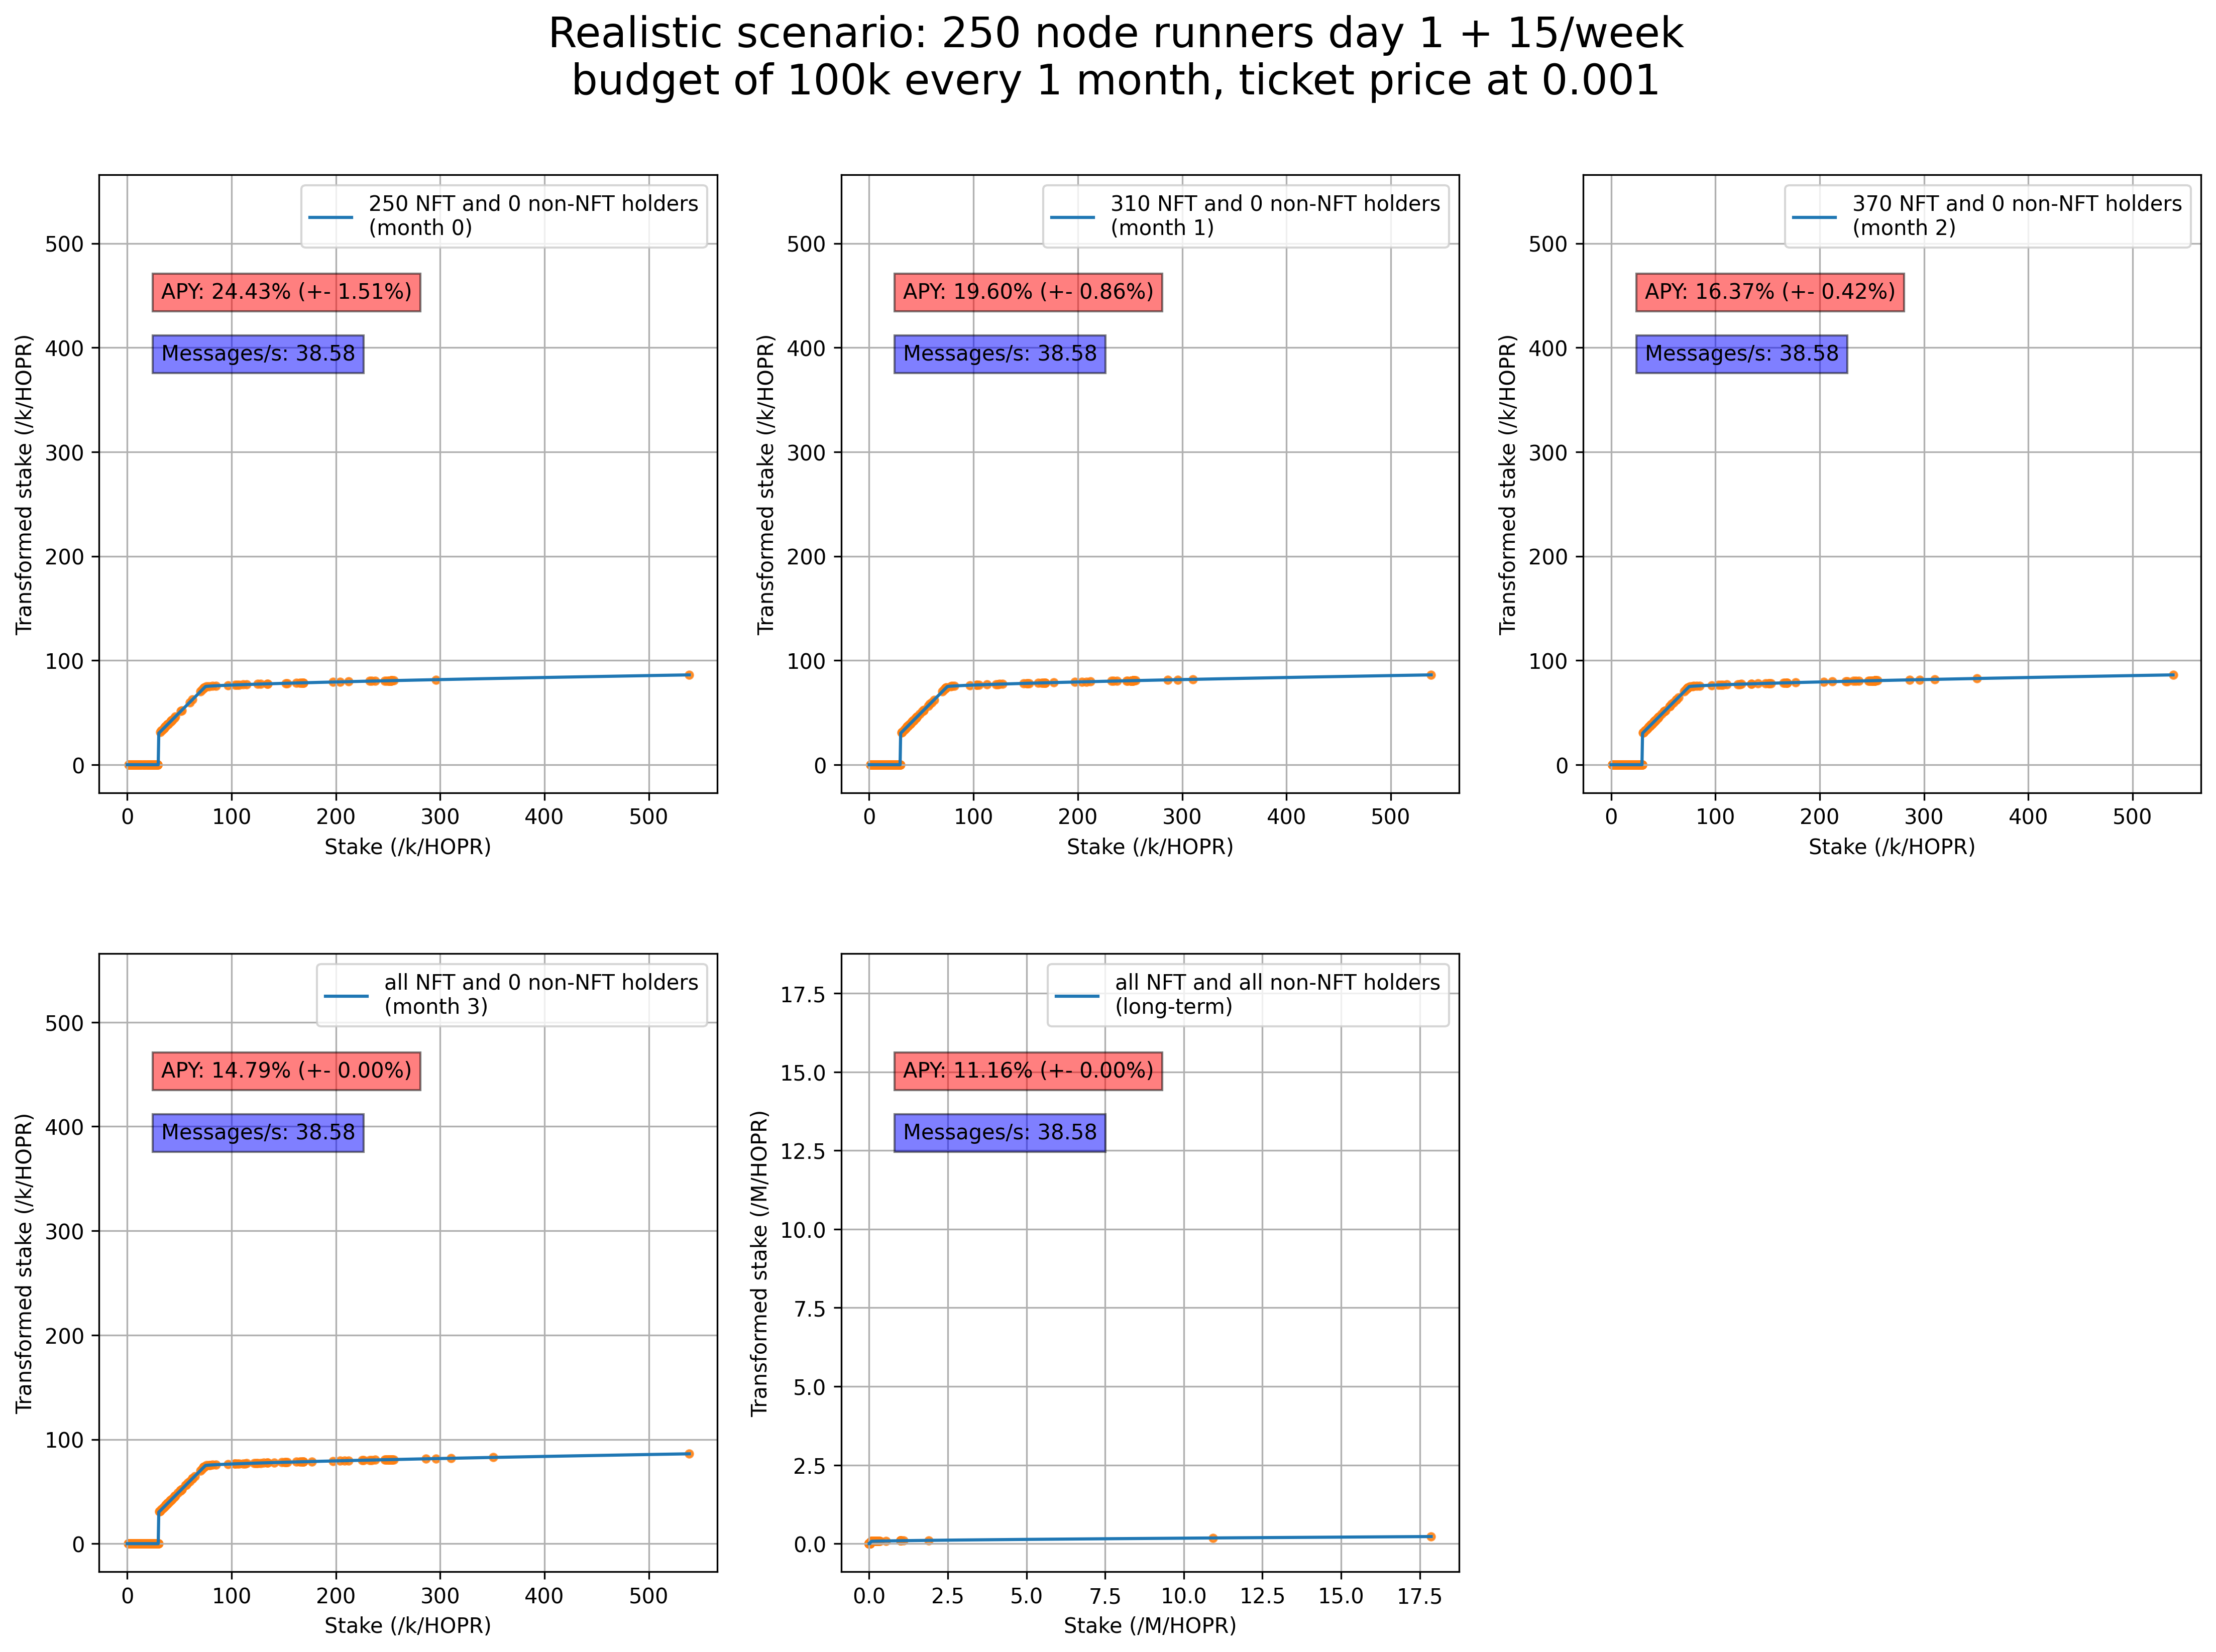

In [4]:
prefered_vars = [deepcopy(prefered) for _ in range(5)]

prefered_vars[0]["data_count"] = [250, 0, 0]
prefered_vars[1]["data_count"] = [310, 0, 0]
prefered_vars[2]["data_count"] = [370, 0, 0]
prefered_vars[3]["data_count"] = ["all", 0, 0]
prefered_vars[4]["data_count"] = ["all", "all", 0]

for idx, opt in enumerate(prefered_vars[:-1]):
    opt["legend"] = f"(month {idx})"

prefered_vars[-1]["legend"] = f"(long-term)"

for idx, opt in enumerate(prefered_vars):
    opt["legend"] = f"{opt['data_count'][0]} NFT and {opt['data_count'][1]} non-NFT holders\n{opt['legend']}"

generate_simulation_graph(datas, prefered_vars, title=f"Realistic scenario: 250 node runners day 1 + 15/week\nbudget of {prefered_vars[0]['budget']/1000:.0f}k every {prefered_vars[0]['period_in_months']} month, ticket price at 0.001")

Average APY: 14.285121710099116
Maximum APY: 14.28512171009912


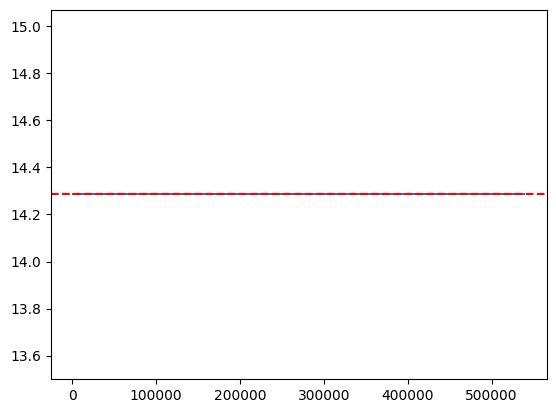

In [5]:
apys = compute_apy(prefered, staking_info_nft_holders, percentage=True, average=False)
average = np.mean([apy for apy, stake in zip(apys, staking_info_nft_holders) if stake > 30e3])

print(f"Average APY: {average}")
print(f"Maximum APY: {max(apys)}")

plt.plot(staking_info_nft_holders, apys)
plt.axhline(average, color="red", linestyle="--")
plt.show()


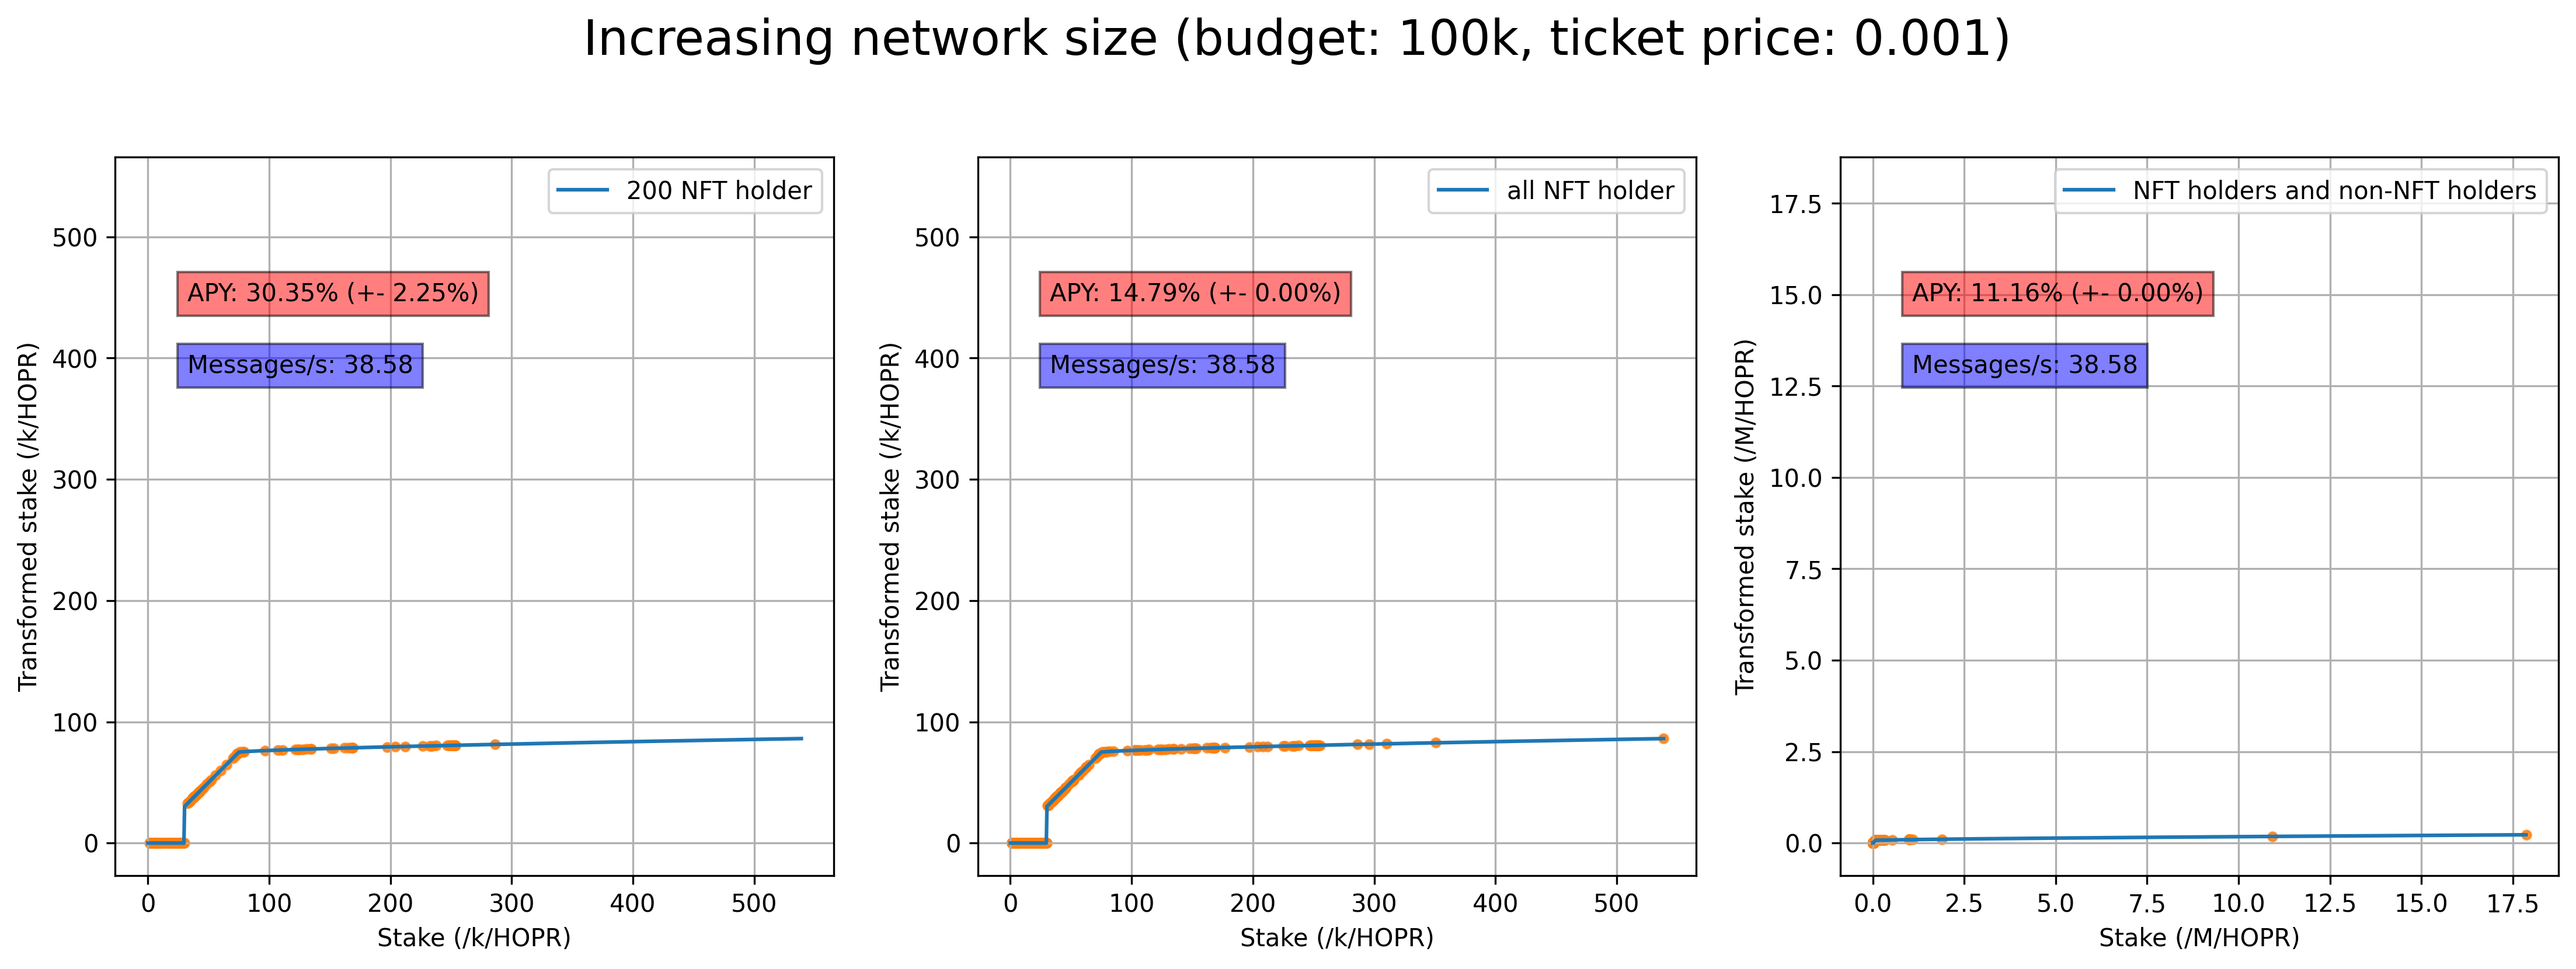

In [6]:
nft_holder_counts = [200, "all"]
options = [deepcopy(prefered) for _ in range(len(nft_holder_counts))]

for opt, count in zip(options, nft_holder_counts):
    opt["data_count"][0] = count
    opt["legend"] = f"{count} NFT holder"

options.append(deepcopy(prefered))

options[-1]["data_count"] = ["all", "all", 0]
options[-1]["legend"] = "NFT holders and non-NFT holders"


generate_simulation_graph(datas, options, title=f"Increasing network size (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']})", cols=3)

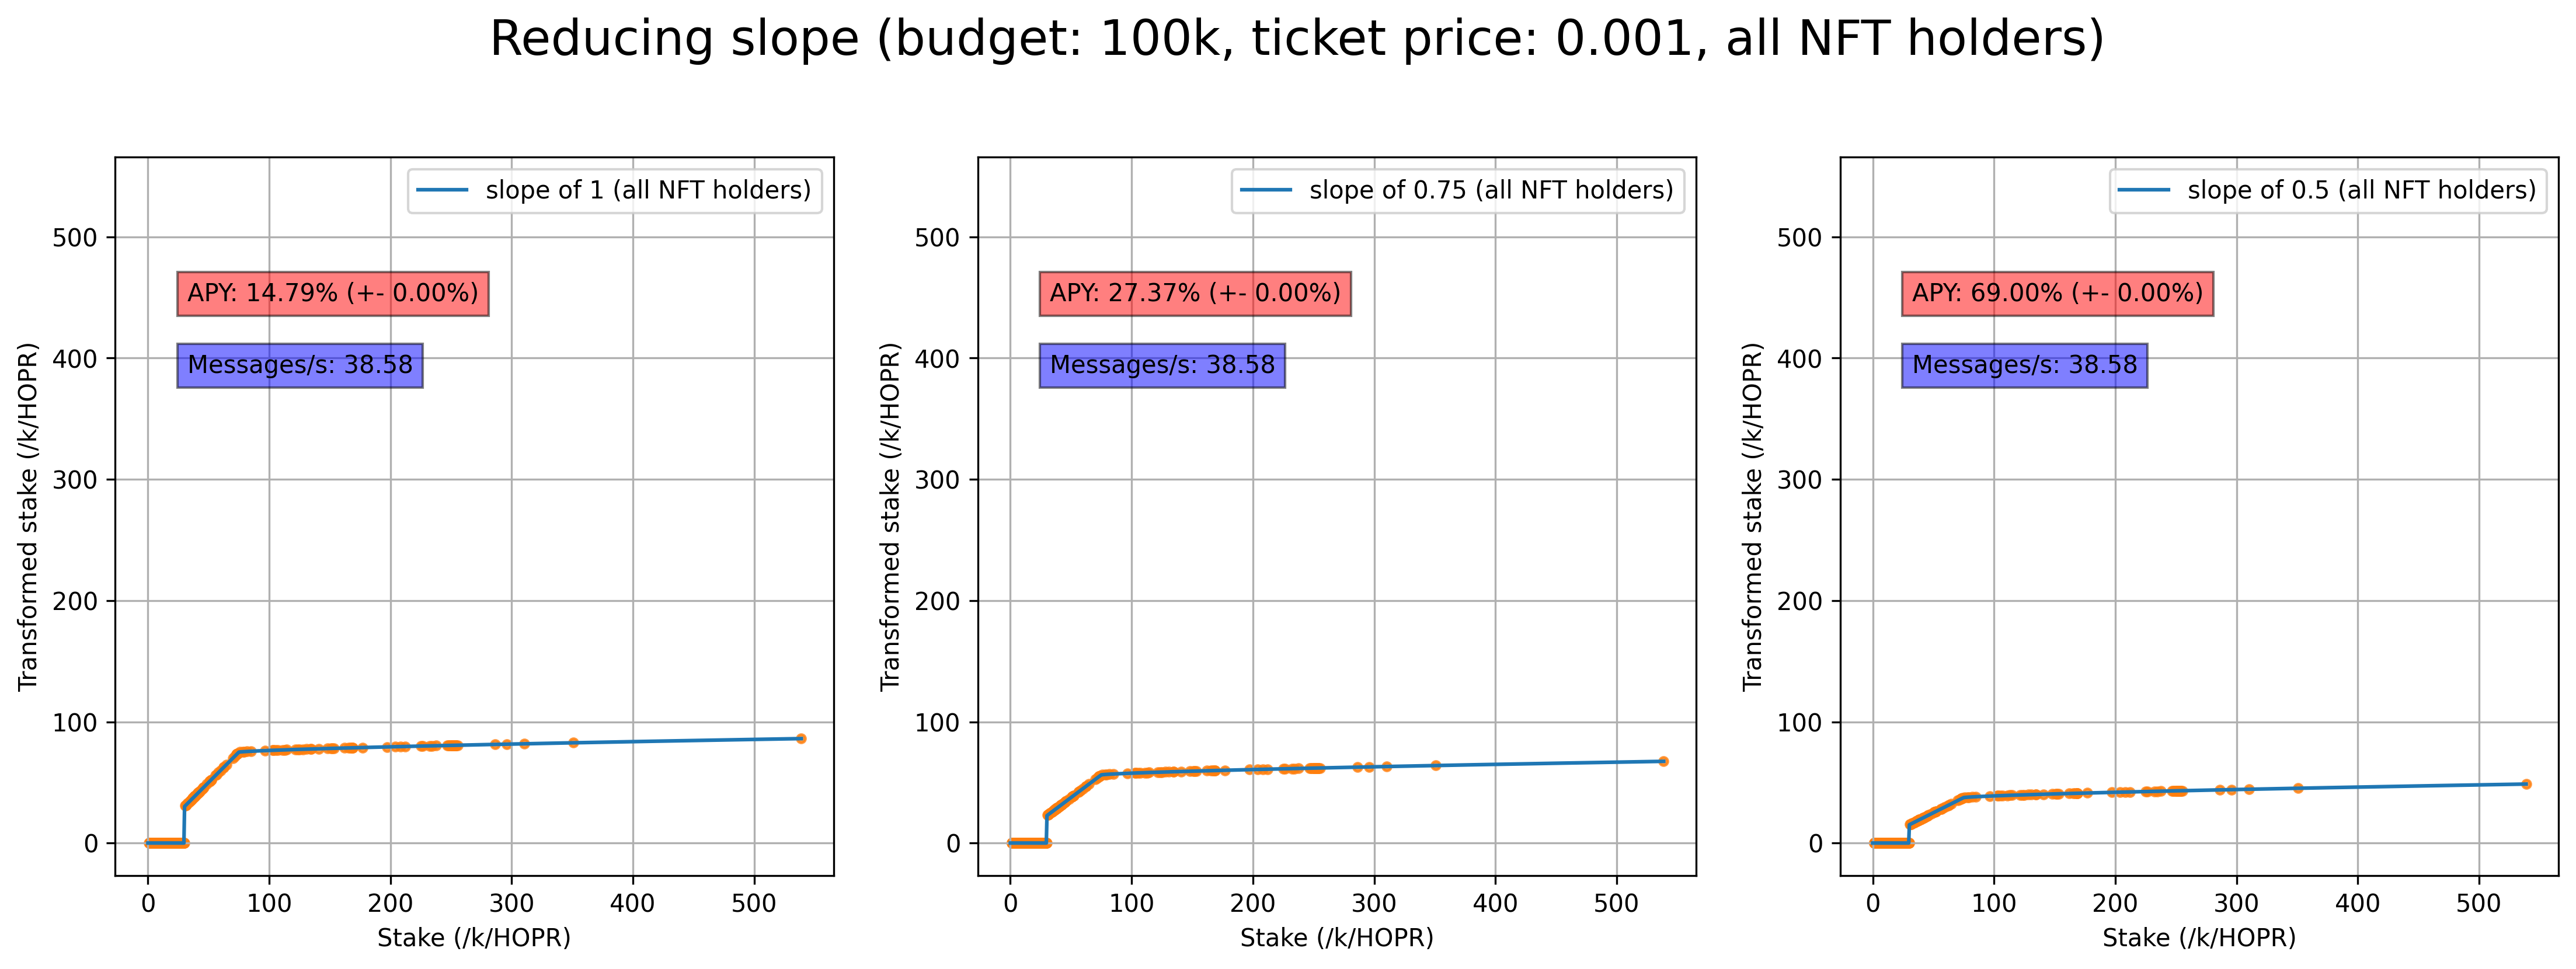

In [7]:
slopes = [1, 0.75, 0.5]
options_nft = [deepcopy(prefered) for _ in range(len(slopes))]

for opt_nft, slope in zip( options_nft, slopes):
    opt_nft["data_count"] = ["all", 0, 0]
    opt_nft["model_arguments"]["slope"] = slope
    opt_nft["legend"] = f"slope of {slope} (all NFT holders)"

generate_simulation_graph(datas, options_nft, 200, title=f"Reducing slope (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']}, all NFT holders)")

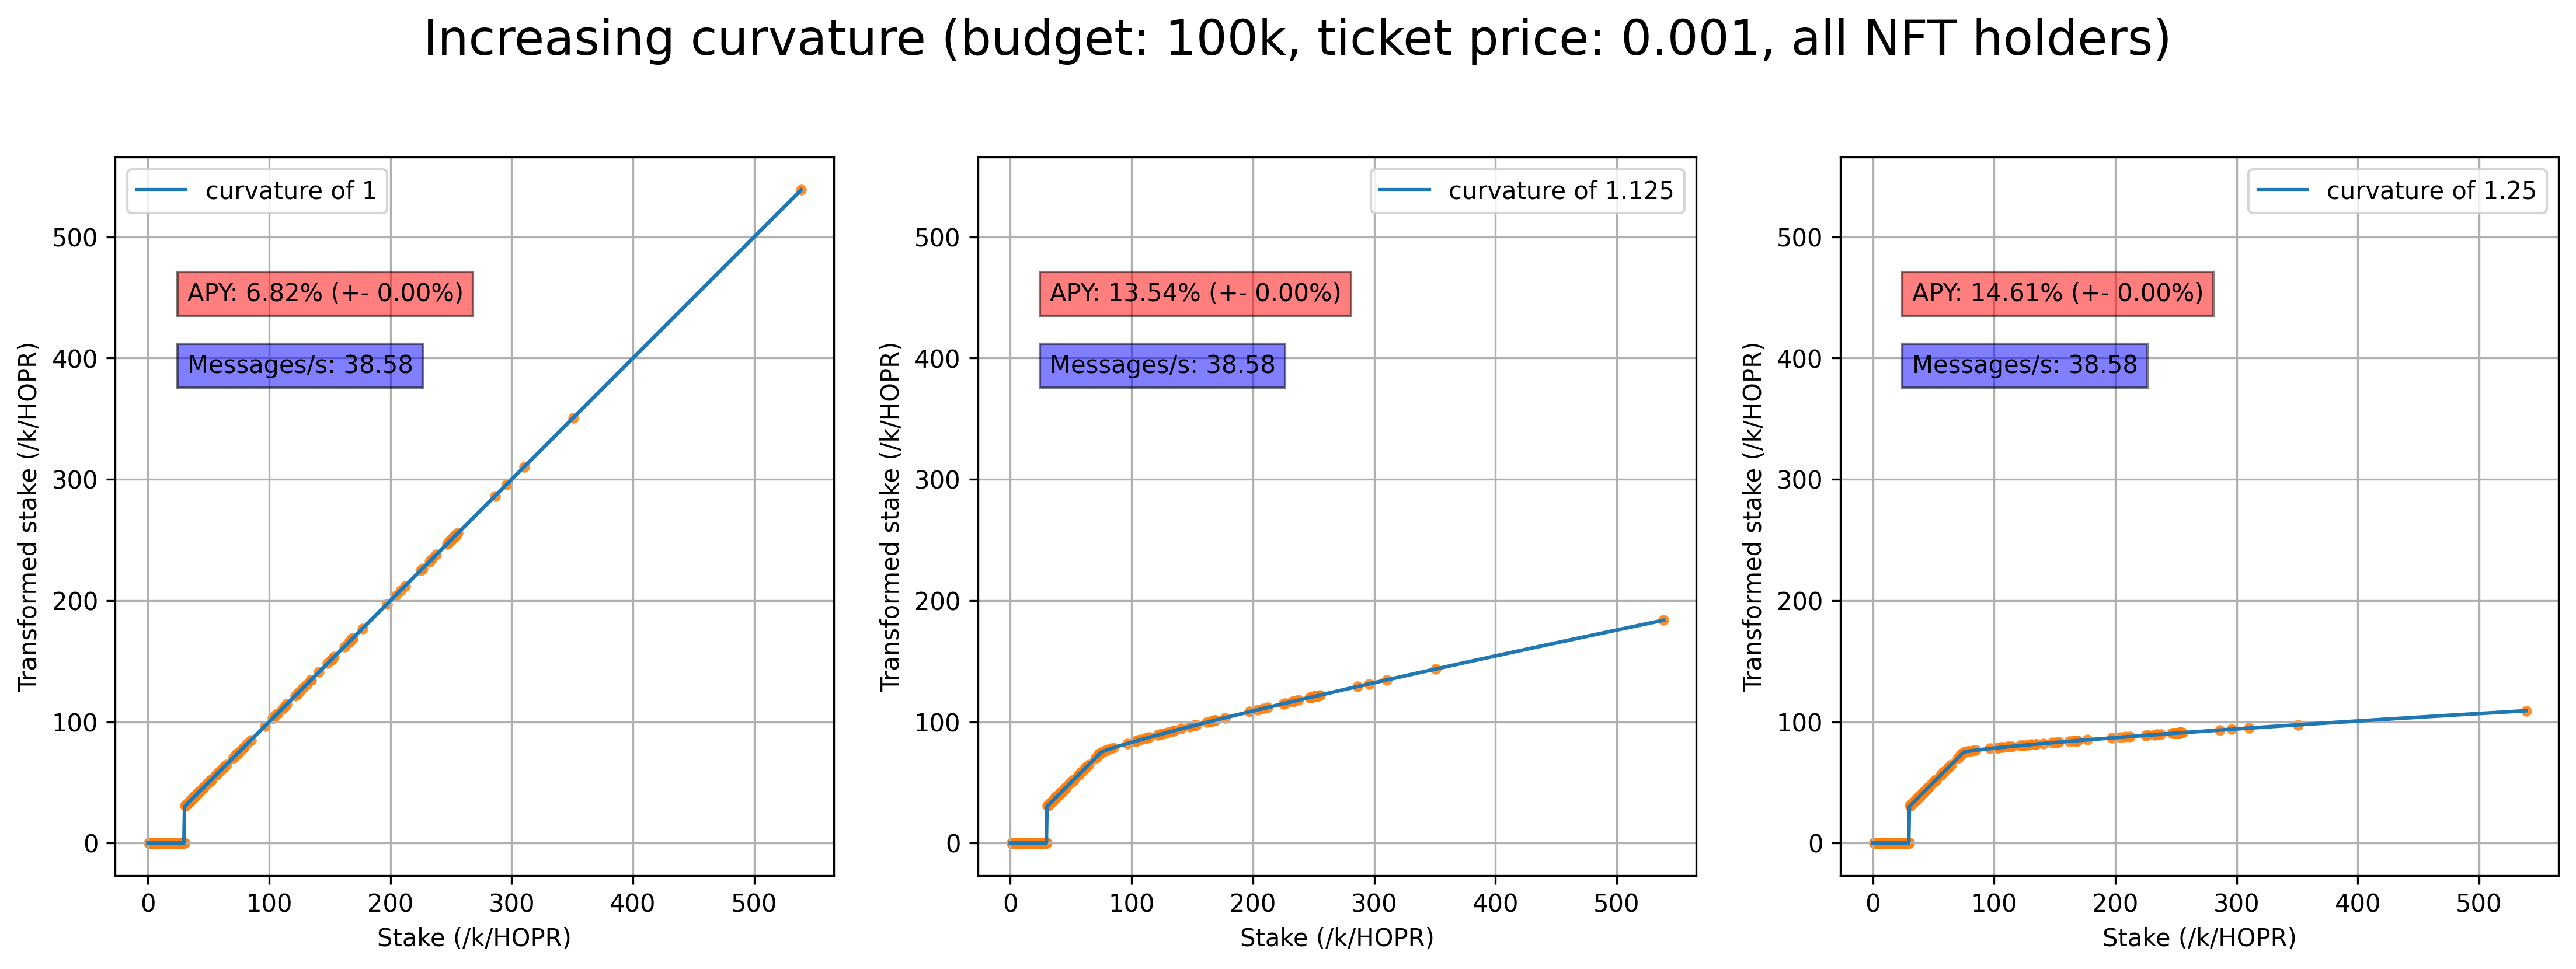

In [8]:
curvatures = [1, 1.125, 1.25]
options = [deepcopy(prefered) for _ in range(len(curvatures))]

for opt, curvature in zip(options, curvatures):
    opt["model_arguments"]["curvature"] = curvature
    opt["legend"] = f"curvature of {curvature}"

generate_simulation_graph(datas, options, 200, title=f"Increasing curvature (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']}, all NFT holders)")



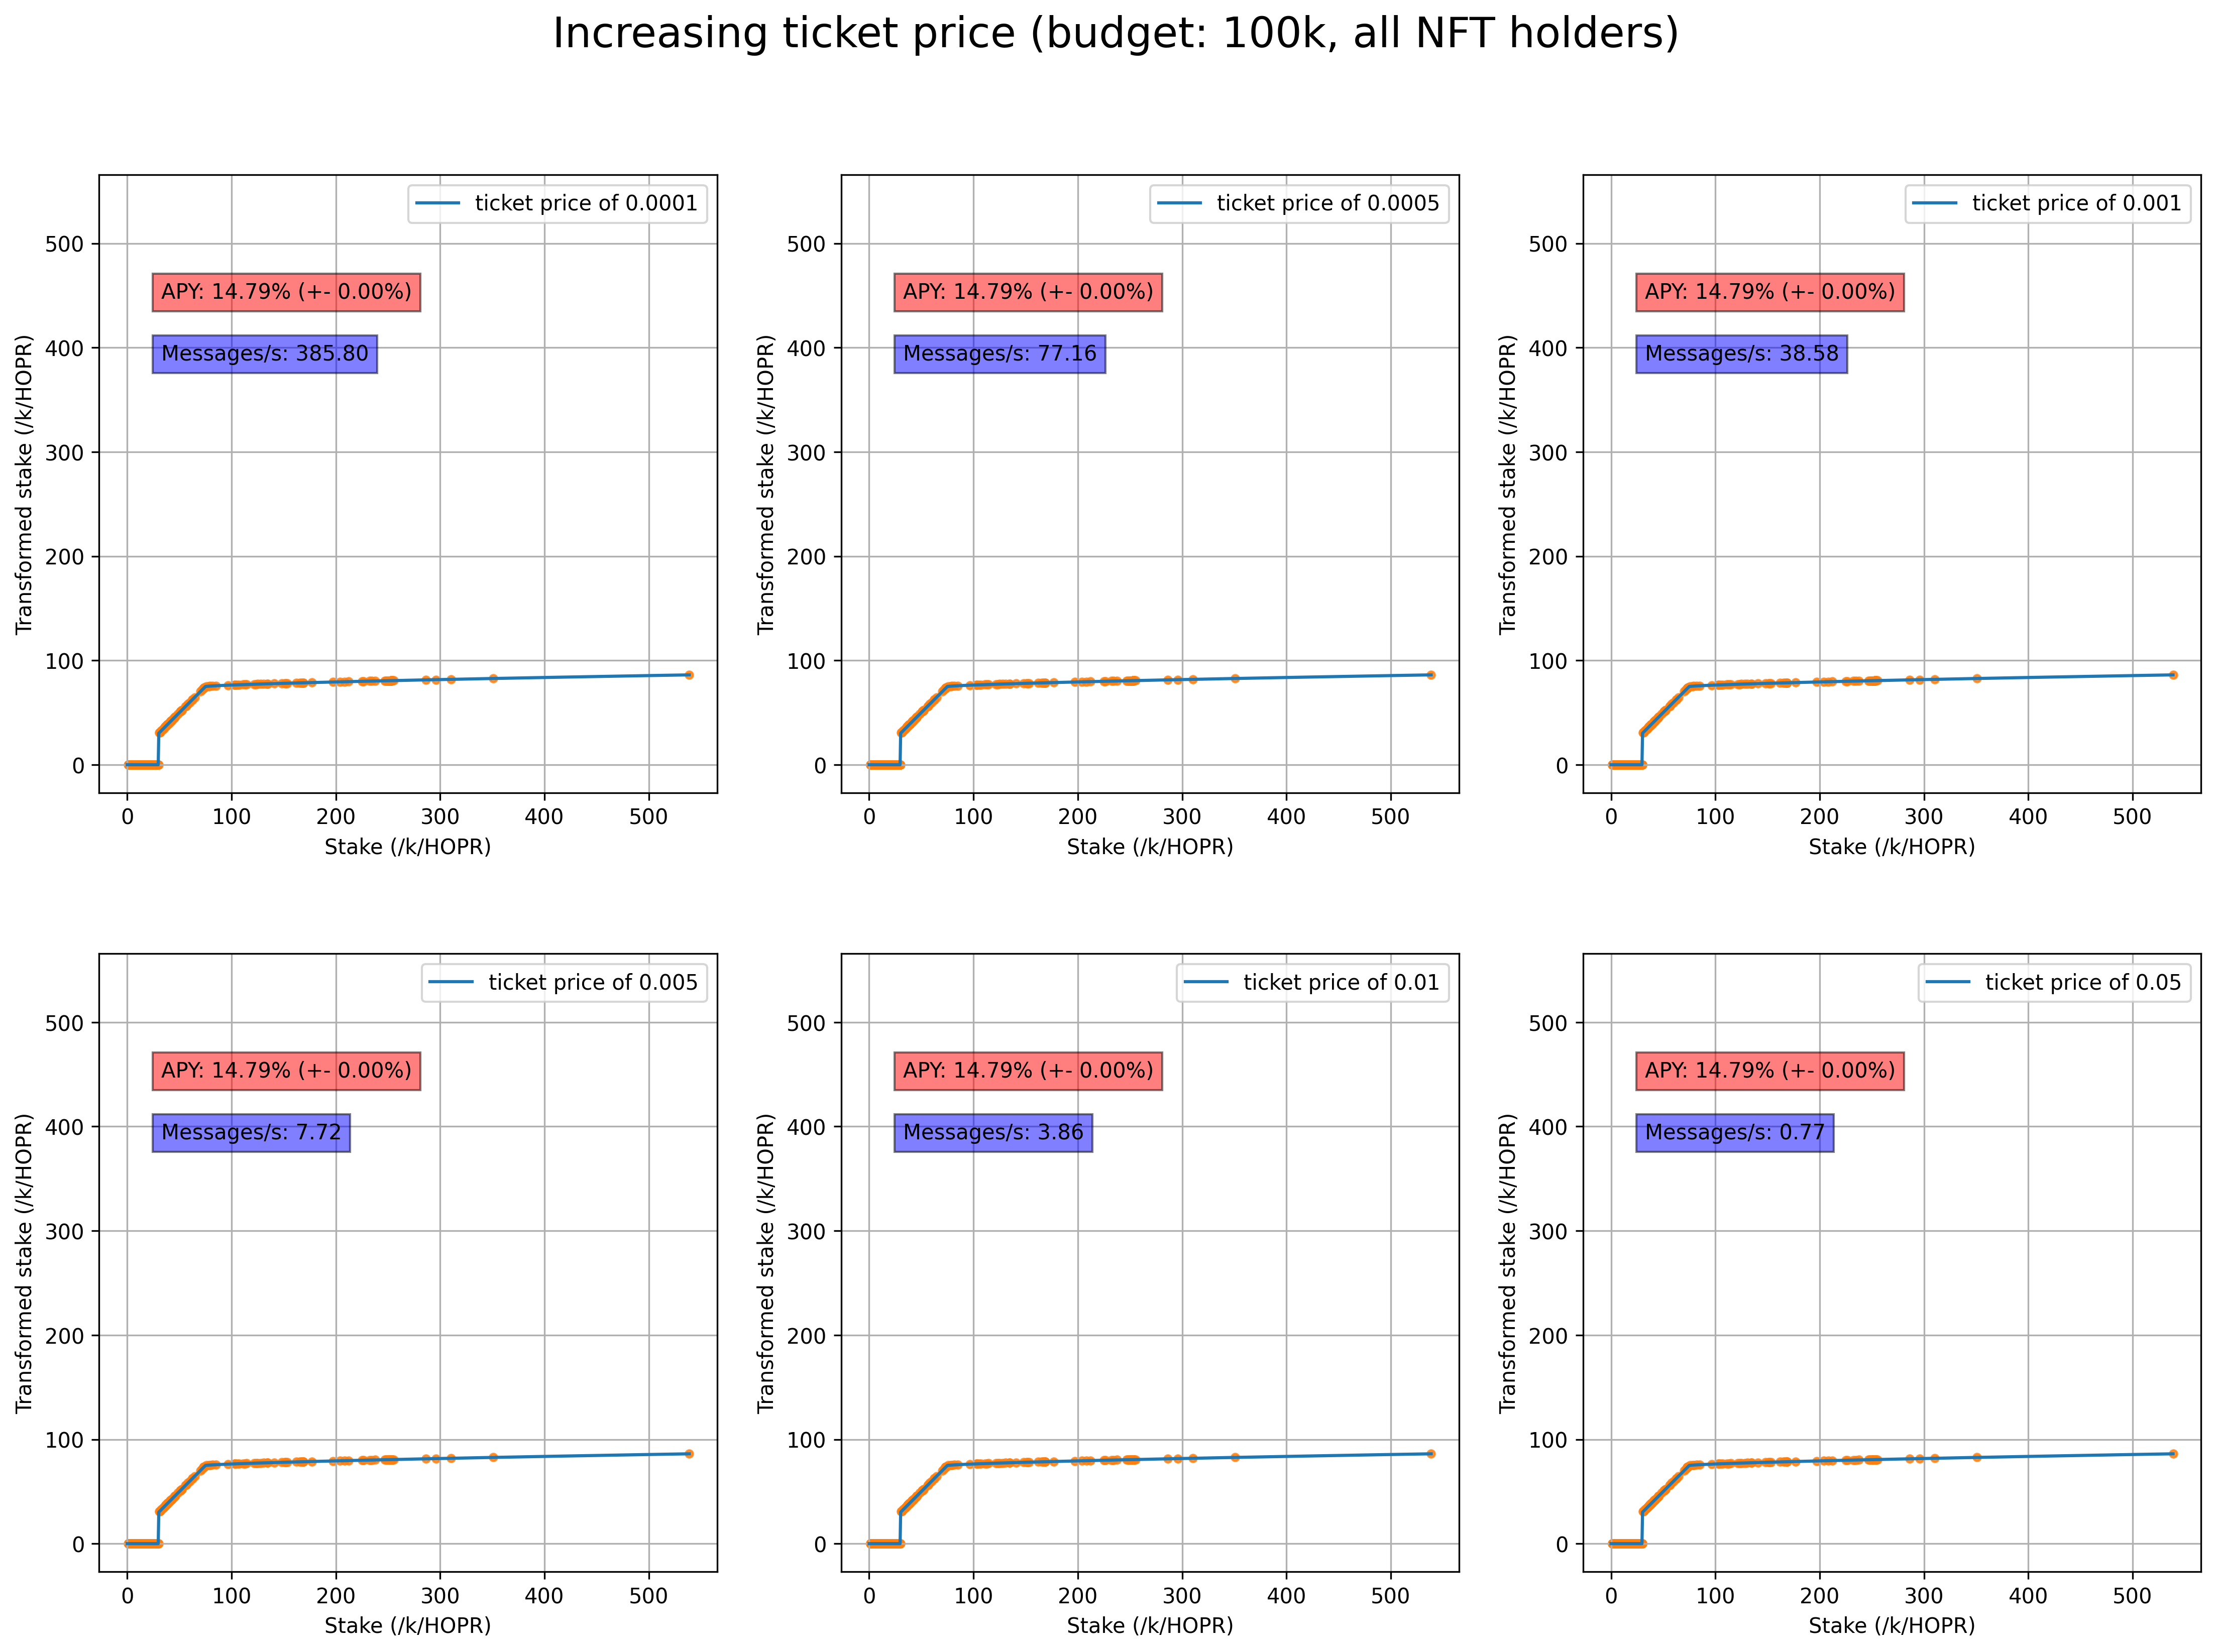

In [9]:
ticket_prices = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
options = [deepcopy(prefered) for _ in range(len(ticket_prices))]

for opt, ticket_price in zip(options, ticket_prices):
    opt["ticket_options"]["price"] = ticket_price
    opt["legend"] = f"ticket price of {ticket_price}"

generate_simulation_graph(datas, options, title=f"Increasing ticket price (budget: {options[0]['budget']/1000:.0f}k, all NFT holders)")

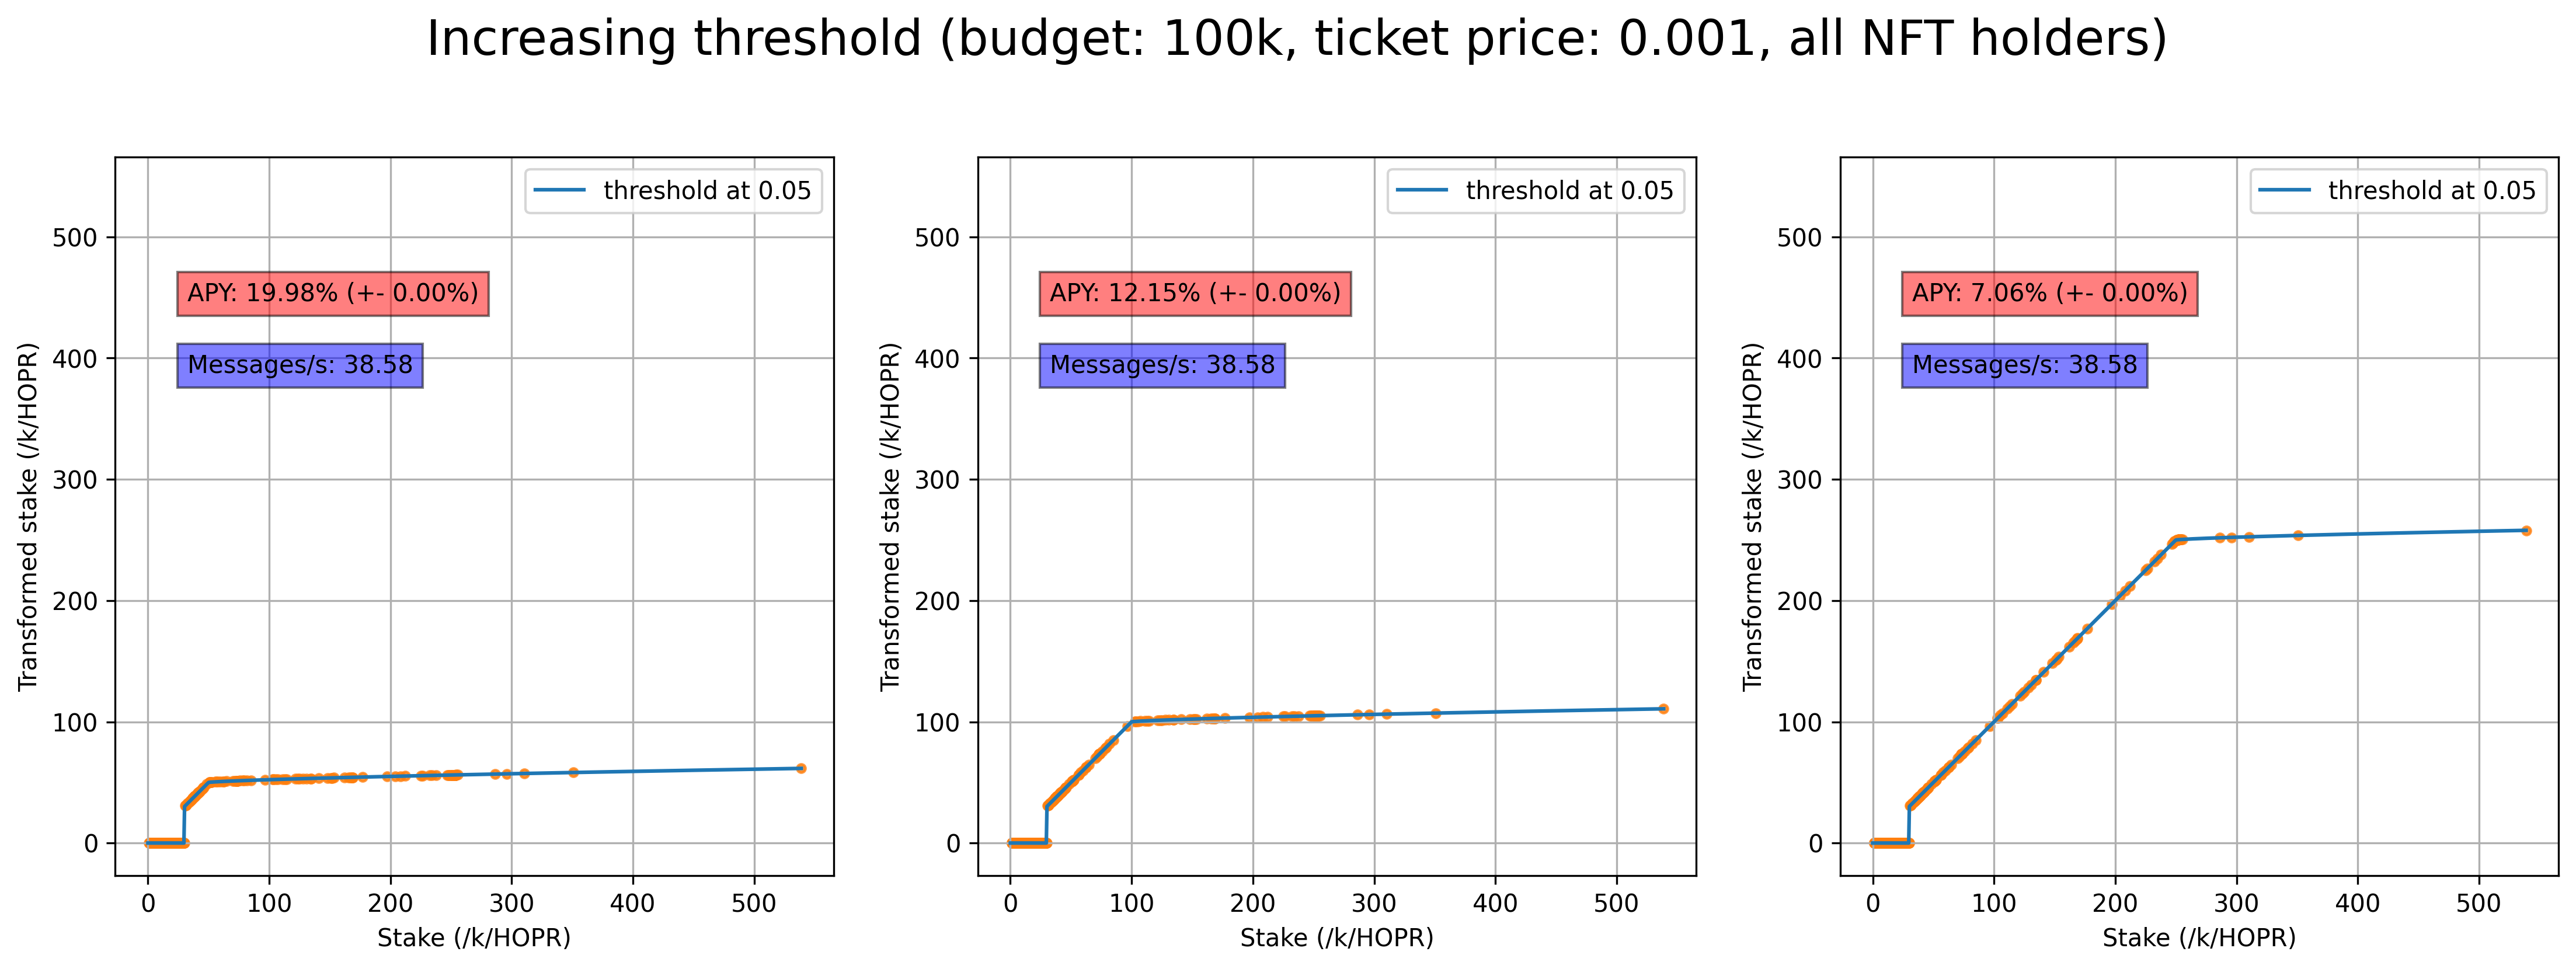

In [10]:
thresholds = [50e3, 100e3, 250e3]
options = [deepcopy(prefered) for _ in range(len(thresholds))]

for opt, threshold in zip(options, thresholds):
    opt["model_arguments"]["threshold"] = threshold
    opt["legend"] = f"threshold at {ticket_price}"


generate_simulation_graph(datas, options, title=f"Increasing threshold (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']}, all NFT holders)")

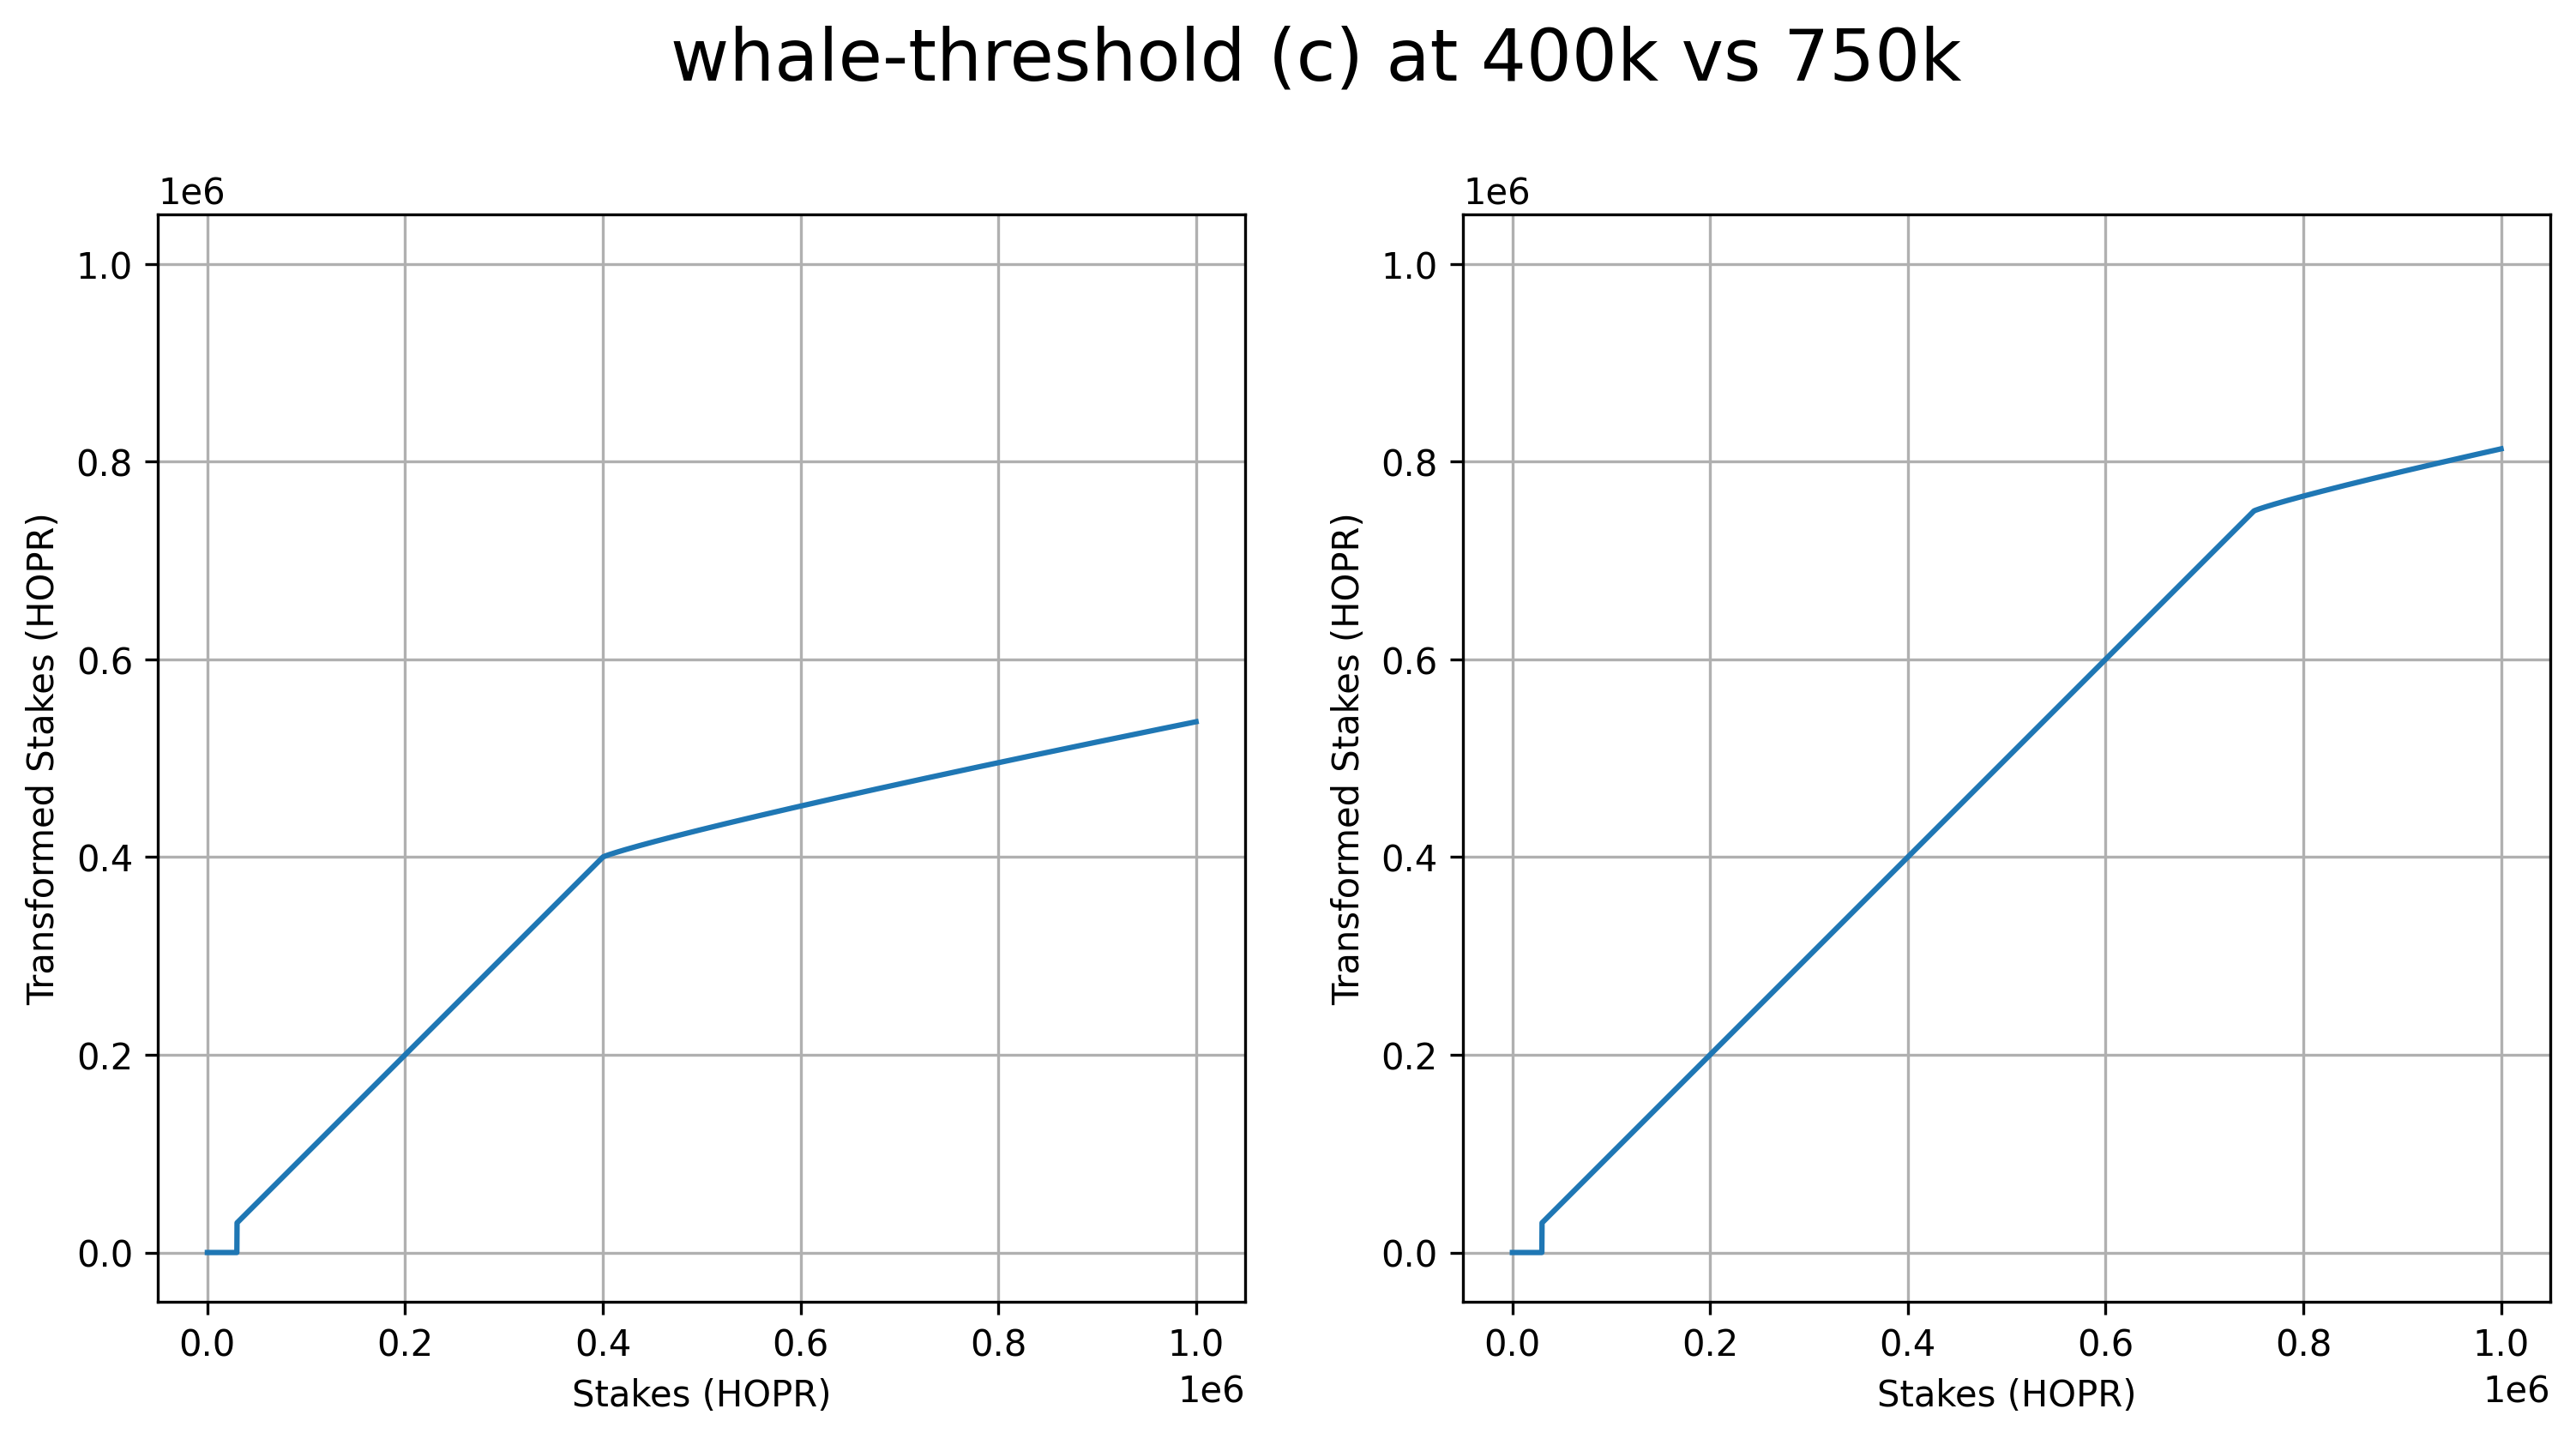

In [11]:
options = [{
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":400e3,
    }
},
{
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":750e3,
    }
}
]

generate_simulation_graph_simple(options, 5000, title="whale-threshold (c) at 400k vs 750k")

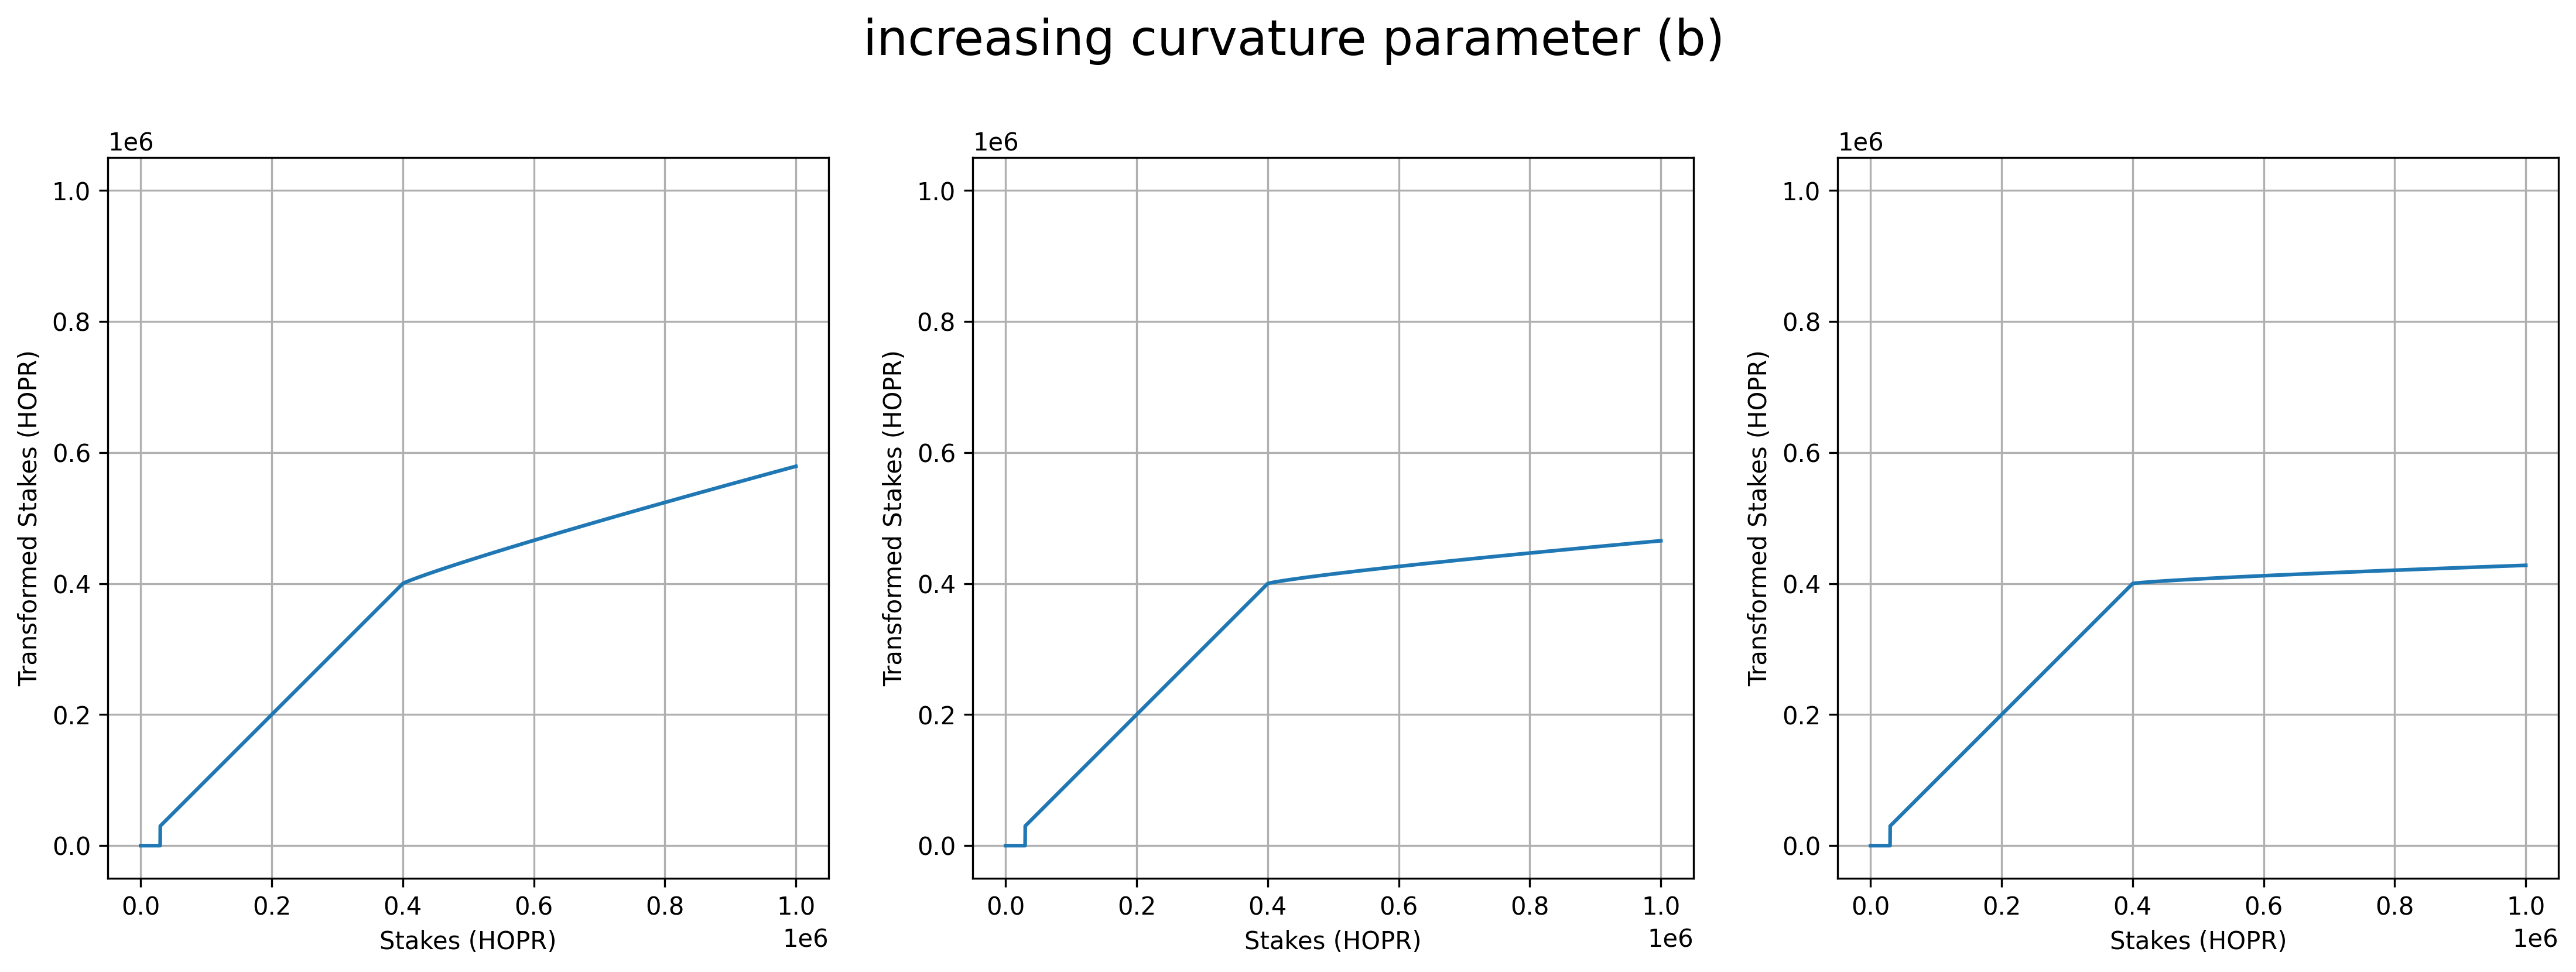

In [12]:
options = [{
    "model_arguments": {
        "slope": 1,
        "curvature":1.1,
        "threshold":400e3,
    }
},
{
    "model_arguments": {
        "slope": 1,
        "curvature":1.200,
        "threshold":400e3,
    }
},
{
    "model_arguments": {
        "slope": 1,
        "curvature":1.3,
        "threshold":400e3,
    }
}
]

generate_simulation_graph_simple(options, 5000, title="increasing curvature parameter (b)")

In [13]:
print(f"min stake: {min(staking_info_nft_holders):.2f} HOPR")
print(f"max stake: {max(staking_info_nft_holders):.2f} HOPR")
print(f"average stake: {np.mean(staking_info_nft_holders):.2f} HOPR")
print(f"median stake: {np.median(staking_info_nft_holders):.2f} HOPR")
print(f"total reward: {sum(list(raw_data[~condition]['rewards_till_now'])):.2f} HOPR")


min stake: 1000.51 HOPR
max stake: 538801.21 HOPR
average stake: 49534.33 HOPR
median stake: 11156.54 HOPR
total reward: 1020837.41 HOPR


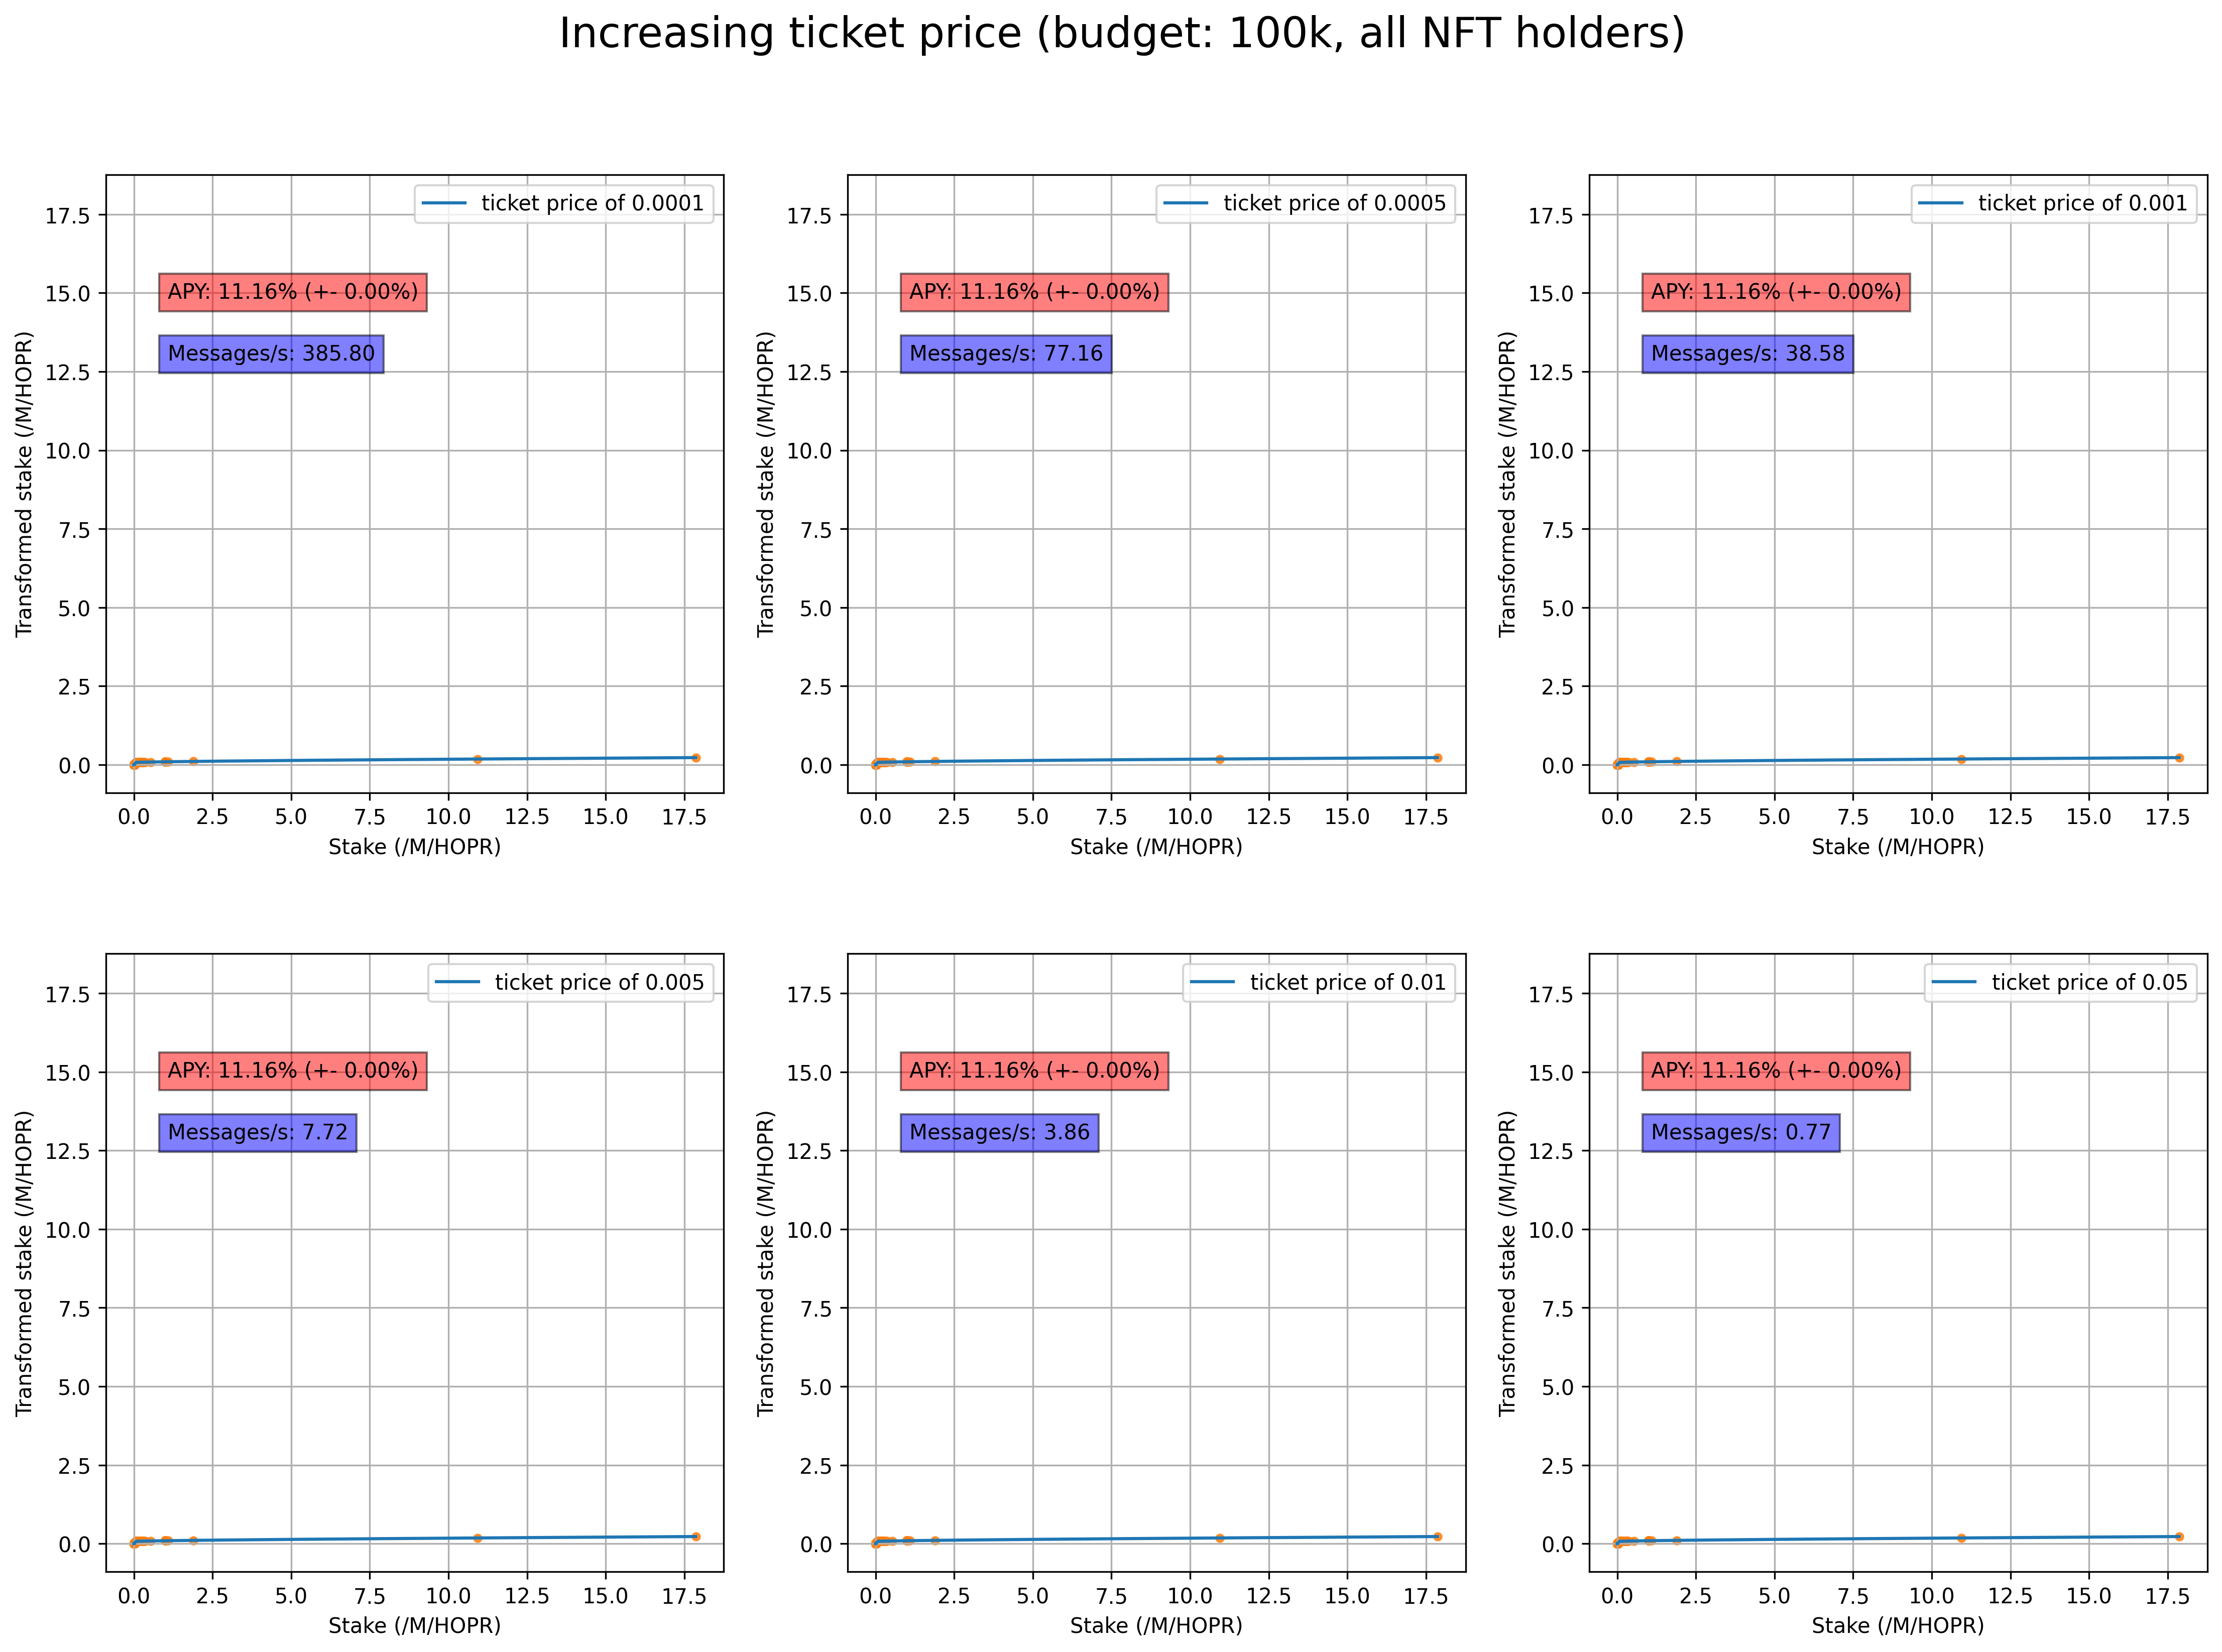

In [14]:
ticket_prices = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
options = [deepcopy(prefered) for _ in range(len(ticket_prices))]

for opt, ticket_price in zip(options, ticket_prices):
    opt["data_count"] = ["all", "all", 0]
    opt["ticket_options"]["price"] = ticket_price
    opt["legend"] = f"ticket price of {ticket_price}"

generate_simulation_graph(datas, options, title=f"Increasing ticket price (budget: {options[0]['budget']/1000:.0f}k, all NFT holders)")

### Table results

In [15]:
counts = [
    [250, 0, 0],
    [310, 0, 0],
    [370, 0, 0],
    ["all", 0, 0],
    ["all", "all", 0],
]
columns = [f"{count[0]} NFT and {count[1]} non-NFT" for count in counts]

In [16]:
curvatures = [1, 1.125, 1.25, 1.375, 1.4, 1.5]
rows = [f"curvature: {curvature:.3f}" for curvature in curvatures]
options = [deepcopy(prefered) for _ in range(len(curvatures))]

for opt, curvature in zip(options, curvatures):
    opt["model_arguments"]["curvature"] = curvature

df_combined = pd.DataFrame(generate_simulation_table(datas, options, counts)[2], rows, columns)

display(df_combined)

,250 NFT and 0 non-NFT,310 NFT and 0 non-NFT,370 NFT and 0 non-NFT,all NFT and 0 non-NFT,all NFT and all non-NFT
curvature: 1.000,11.17% / 38.58m/s,9.08% / 38.58m/s,7.55% / 38.58m/s,6.82% / 38.58m/s,2.03% / 38.58m/s
curvature: 1.125,22.04% / 38.58m/s,17.88% / 38.58m/s,14.93% / 38.58m/s,13.54% / 38.58m/s,9.24% / 38.58m/s
curvature: 1.250,24.12% / 38.58m/s,19.34% / 38.58m/s,16.17% / 38.58m/s,14.61% / 38.58m/s,10.92% / 38.58m/s
curvature: 1.375,24.11% / 38.58m/s,19.48% / 38.58m/s,16.37% / 38.58m/s,14.78% / 38.58m/s,11.15% / 38.58m/s
curvature: 1.400,24.26% / 38.58m/s,19.62% / 38.58m/s,16.35% / 38.58m/s,14.79% / 38.58m/s,11.16% / 38.58m/s
curvature: 1.500,24.26% / 38.58m/s,19.59% / 38.58m/s,16.46% / 38.58m/s,14.82% / 38.58m/s,11.19% / 38.58m/s


In [17]:
thresholds = [50e3, 75e3, 100e3, 150e3, 250e3]
rows = [f"threshold: {int(threshold/1e3)}k" for threshold in thresholds]
options = [deepcopy(prefered) for _ in range(len(thresholds))]

for opt, threshold in zip(options, thresholds):
    opt["model_arguments"]["threshold"] = threshold

df_combined = pd.DataFrame(generate_simulation_table(datas, options, counts)[2], rows, columns)

display(df_combined)

,250 NFT and 0 non-NFT,310 NFT and 0 non-NFT,370 NFT and 0 non-NFT,all NFT and 0 non-NFT,all NFT and all non-NFT
threshold: 50k,32.82% / 38.58m/s,26.34% / 38.58m/s,22.07% / 38.58m/s,19.98% / 38.58m/s,15.17% / 38.58m/s
threshold: 75k,24.29% / 38.58m/s,19.49% / 38.58m/s,16.34% / 38.58m/s,14.79% / 38.58m/s,11.16% / 38.58m/s
threshold: 100k,19.76% / 38.58m/s,16.01% / 38.58m/s,13.44% / 38.58m/s,12.15% / 38.58m/s,9.12% / 38.58m/s
threshold: 150k,15.35% / 38.58m/s,12.40% / 38.58m/s,10.29% / 38.58m/s,9.33% / 38.58m/s,6.93% / 38.58m/s
threshold: 250k,11.65% / 38.58m/s,9.36% / 38.58m/s,7.77% / 38.58m/s,7.06% / 38.58m/s,5.19% / 38.58m/s


In [18]:
ticket_prices = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
rows = [f"ticket price: {price}" for price in ticket_prices]
options = [deepcopy(prefered) for _ in range(len(ticket_prices))]

for opt, price in zip(options, ticket_prices):
    opt["ticket_options"]["price"] = price

df_combined = pd.DataFrame(generate_simulation_table(datas, options, counts)[2], rows, columns)

display(df_combined)

,250 NFT and 0 non-NFT,310 NFT and 0 non-NFT,370 NFT and 0 non-NFT,all NFT and 0 non-NFT,all NFT and all non-NFT
ticket price: 0.0001,24.30% / 385.80m/s,19.60% / 385.80m/s,16.34% / 385.80m/s,14.79% / 385.80m/s,11.16% / 385.80m/s
ticket price: 0.0005,24.15% / 77.16m/s,19.64% / 77.16m/s,16.40% / 77.16m/s,14.79% / 77.16m/s,11.16% / 77.16m/s
ticket price: 0.001,24.43% / 38.58m/s,19.54% / 38.58m/s,16.43% / 38.58m/s,14.79% / 38.58m/s,11.16% / 38.58m/s
ticket price: 0.005,24.37% / 7.72m/s,19.57% / 7.72m/s,16.37% / 7.72m/s,14.79% / 7.72m/s,11.16% / 7.72m/s
ticket price: 0.01,24.37% / 3.86m/s,19.60% / 3.86m/s,16.42% / 3.86m/s,14.79% / 3.86m/s,11.16% / 3.86m/s
ticket price: 0.05,24.11% / 0.77m/s,19.62% / 0.77m/s,16.35% / 0.77m/s,14.79% / 0.77m/s,11.16% / 0.77m/s


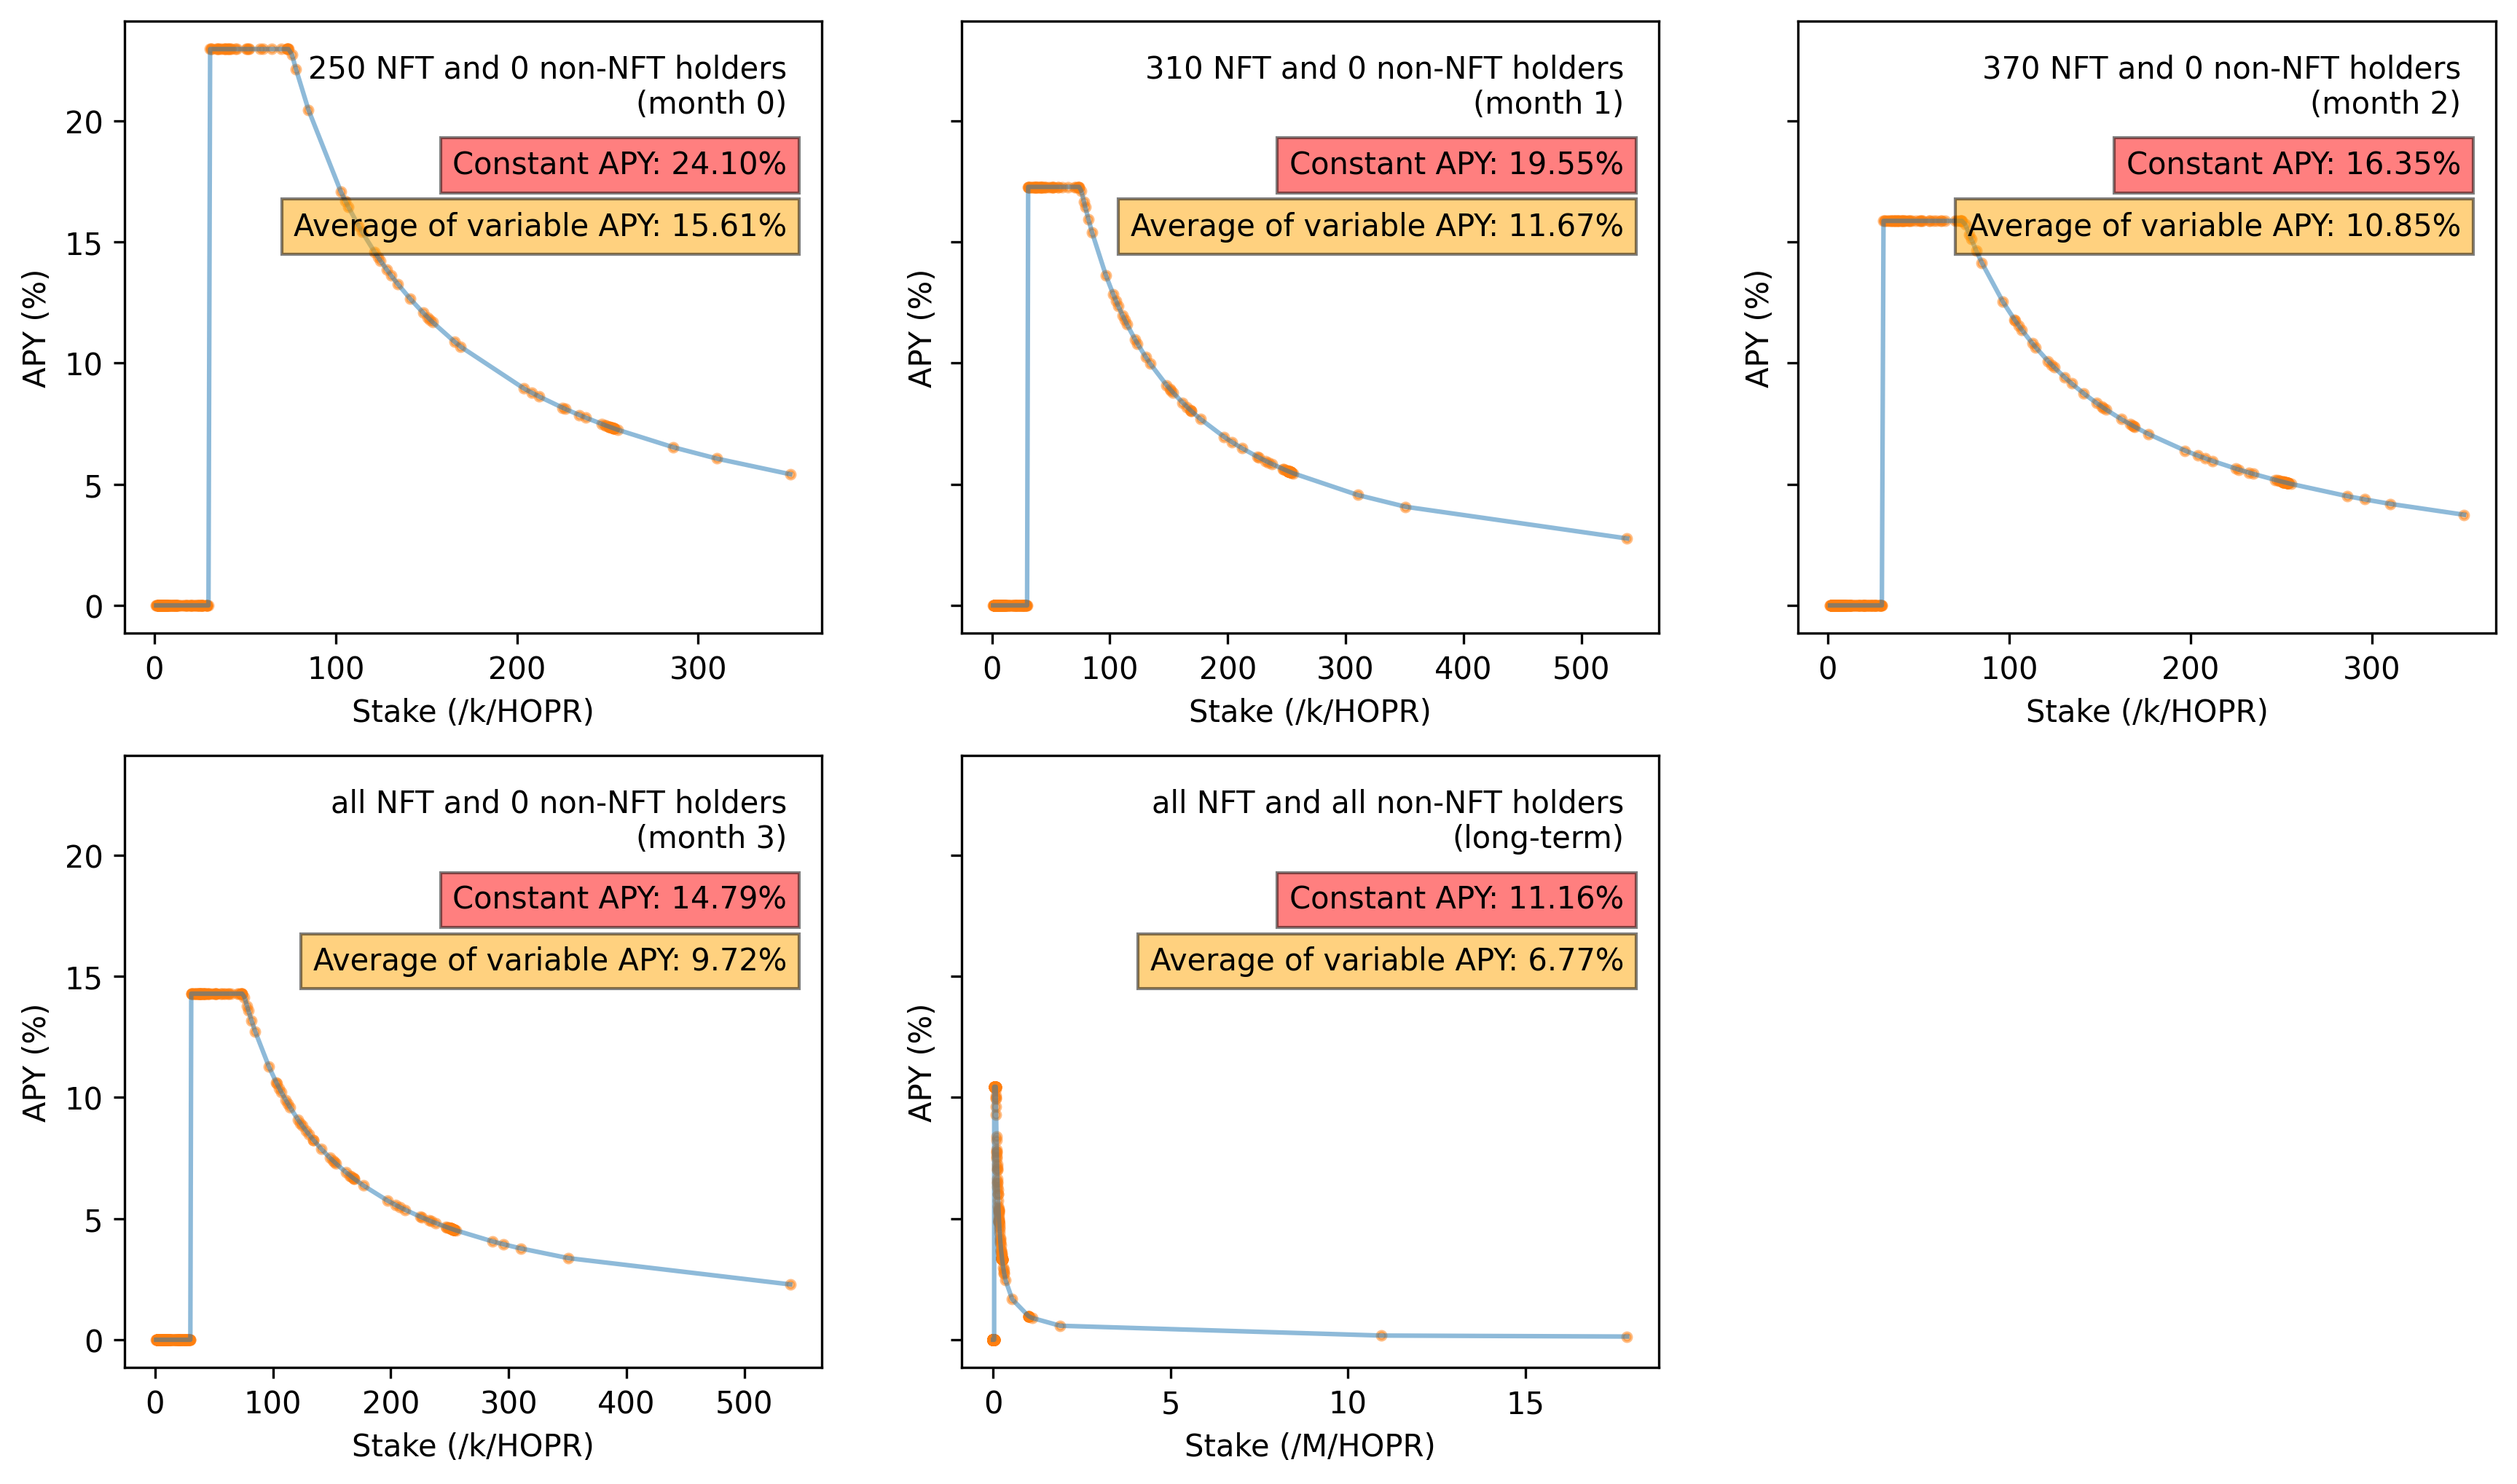

In [19]:

_, axes = plt.subplots(2, 3, figsize=(14, 8), dpi=300, sharey=True)
axes = axes.flatten()
options = deepcopy(prefered_vars)

for opt, ax in zip(options, axes):
    stakes = []

    for data, count in zip(datas, opt["data_count"]):
        if not count:
            continue
        if count == "all":
            stakes.extend(data)
        else:
            stakes.extend(random.sample(data, count))        

    stakes = sorted(stakes)

    lin_range = np.linspace(0, max(stakes), 1000)

    apys = compute_apy(opt, stakes, percentage=True, average=False, on_stake=True)
    global_apy = probabilistic_apy(datas, [opt], steps=200)[0]["average"] * 100

    average_apy = np.mean([apy for apy, stake in zip(apys, stakes) if stake > 30e3])
    factor, prefix = factor_and_prefix(stakes[-1])

    stakes = [s/factor for s in stakes]
    
    ax.plot(stakes, apys, alpha=0.5)
    ax.scatter(stakes, apys, s=8, c="#ff7f0e", alpha=0.5)
    ax.text(0.95,
            0.85,
            opt["legend"],
            transform=ax.transAxes,
            horizontalalignment='right')    
    ax.text(0.95,
            0.75,
            f"Constant APY: {global_apy:.2f}%",
            transform=ax.transAxes,
            horizontalalignment='right',
            bbox=dict(facecolor='red', alpha=0.5),)
    ax.text(0.95,
            0.65,
            f"Average of variable APY: {average_apy:.2f}%",
            transform=ax.transAxes,
            horizontalalignment='right',
            bbox=dict(facecolor='orange', alpha=0.5),)
    

    ax.set_xlabel(f"Stake (/{prefix}/HOPR)")
    ax.set_ylabel("APY (%)")

# remove unused subplots
for ax in axes[len(options):]:
    ax.remove()

plt.show()

In [29]:
investor_node_count = [1, 25, 50, 100, 400]
hopr_value = 0.041
investor_budget = 0.5e6 / hopr_value

def split_to_buckets(value, bucket_count, min_amount, max_amount):
    average = value / bucket_count

    if max_amount >= average and average >= min_amount:
        return [average] * bucket_count
    
    if average < min_amount:
        return split_to_buckets(value, bucket_count-1, min_amount, max_amount) + [0]
    
    filled_buckets = min(int(value / max_amount), bucket_count -1)
    remaining_value = value - filled_buckets * max_amount
    remaining_buckets = bucket_count - filled_buckets

    return [max_amount] * filled_buckets + split_to_buckets(remaining_value, remaining_buckets, min_amount, max_amount*2)

for node_count in investor_node_count:
    datas = [staking_info_nft_holders, staking_info_non_nft_holders, [investor_budget / node_count]*node_count]

    # datas = [staking_info_nft_holders, staking_info_non_nft_holders, split_to_buckets(investor_budget, node_count, 30e3, 75e3)]

    options = [deepcopy(prefered) for _ in range(2)]

    options[0]["data_count"] = ["all", 0, "all"]
    options[1]["data_count"] = ["all", "all", "all"]

    apys = probabilistic_apy(datas, options, 200)

    print(f"Investor with {int(investor_budget):,}HOPR and {node_count} nodes in the network")
    for idx, (opt, apy) in enumerate(zip(options, apys)):
        opt["legend"] = f"{opt['data_count'][0]} NFT and {opt['data_count'][1]} non-NFT holders {opt['data_count'][2]} investors nodes "

        if opt["data_count"][2] == "all":
            tf_stakes = stake_transformation(datas[2], **opt["model_arguments"])
        else:
            tf_stakes = [0]

        reward = [tf_stake * apy["average"] for tf_stake in tf_stakes] 

        print(f"    {opt['legend']}: {sum(reward):,.2f}HOPR -> {sum(reward)/investor_budget:.2%} APY (network APY: {apy['average']:.2%})" )


    # generate_simulation_graph(datas, options, title=f"Realistic scenario: 250 node runners day 1 + 15/week\nbudget of {prefered_vars[0]['budget']/1000:.0f}k every {prefered_vars[0]['period_in_months']} month, ticket price at 0.001", cols=2)

Investor with 12,195,121HOPR and 1 nodes in the network
    all NFT and 0 non-NFT holders all investors nodes : 27,793.21HOPR -> 0.23% APY (network APY: 14.65%)
    all NFT and all non-NFT holders all investors nodes : 21,024.41HOPR -> 0.17% APY (network APY: 11.08%)
Investor with 12,195,121HOPR and 25 nodes in the network
    all NFT and 0 non-NFT holders all investors nodes : 255,642.08HOPR -> 2.10% APY (network APY: 11.99%)
    all NFT and all non-NFT holders all investors nodes : 202,316.67HOPR -> 1.66% APY (network APY: 9.49%)
Investor with 12,195,121HOPR and 50 nodes in the network
    all NFT and 0 non-NFT holders all investors nodes : 405,972.74HOPR -> 3.33% APY (network APY: 10.10%)
    all NFT and all non-NFT holders all investors nodes : 332,251.11HOPR -> 2.72% APY (network APY: 8.26%)
Investor with 12,195,121HOPR and 100 nodes in the network
    all NFT and 0 non-NFT holders all investors nodes : 592,245.36HOPR -> 4.86% APY (network APY: 7.67%)
    all NFT and all non-NFT h

In [21]:
apys[0]["average"]

0.14792276982650635